# Convergence

Always run these first two cells before going to the desired case. This file contains the convergence results (hypervolume specifically) for the base case (3 objectives), the irrigation case (11 objectives), the hydropower case (8 objectives) and the full case (16 objectives). The normalization of the hypervolume is currently incorrect!

In [4]:
# Imports
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from ema_workbench import (MultiprocessingEvaluator, ema_logging, RealParameter, ScalarOutcome, Constant,
                           Model, HypervolumeMetric, save_results)
from ema_workbench.em_framework.optimization import (GenerationalBorg, epsilon_nondominated, to_problem, ArchiveLogger,
                                                     EpsilonProgress)
import tarfile
import os
import pandas as pd
import pickle

# Make sure we are in the correct folder (used for repetitions)
if not os.path.exists("../src"):
    os.chdir("../../src")
else:
    os.chdir('../src')
os.getcwd()


#Hypervolume hvwfg
# This section was added due to an error in loading the hvwfg (walking fish group hypervolume). Please adapt/remove based on your own device
import sys
sys.path
path = r'C:\users\whitl\appdata\local\packages\pythonsoftwarefoundation.python.3.11_qbz5n2kfra8p0\localcache\local-packages\python311\site-packages'
sys.path.append(path)
sys.path

import hvwfg

In [5]:
# This function loads the archives/runtime files, produces a reference set and calculates the hypervolume (hv) metric. The hypervolume is returned as a dictionary. 
# The normalized hypervolume is incorrectly computed, but left in the code in case a next person wants to improve it. 
def process_archives(seeds, worst_array, norm_worst_array):
    all_norm_hvs = []
    norm_hvs_dict = {}
    hvs_dict = {}

    for i in range(seeds):
        norm_hvs_dict[i] = {}
        hvs_dict[i] = {}

        norm_hvs_this_seed = []
        hvs_this_seed = []
        archives, norm_archives = ArchiveLogger.load_archives(f"archives/{i}.csv")

        sorted_archives = dict(sorted(archives.items()))
        for key, value in sorted_archives.items():
            o = value.values
            objs = np.ascontiguousarray(o)
            hv = hvwfg.wfg(objs, worst_array)
            hvs_this_seed.append(hv)
            hvs_dict[i][int(key)] = hv

        #incorrect normalized hv
        norm_sorted_archives = dict(sorted(norm_archives.items()))
        for key, value in norm_sorted_archives.items():
            o = value.values
            norm_objs = np.ascontiguousarray(o)
            norm_hv = hvwfg.wfg(norm_objs, norm_worst_array)
            norm_hvs_this_seed.append(norm_hv)
            norm_hvs_dict[i][int(key)] = norm_hv

        all_norm_hvs.append(norm_hvs_this_seed)


    return hvs_dict, norm_hvs_dict

# BASE CASE

In [7]:
# Model definition

from model_zambezi_OPT import ModelZambezi

ZambeziProblem = ModelZambezi()

def model_wrapper(**kwargs):
    input = [kwargs['v' + str(i)] for i in range(len(kwargs))]
    # print('len kwargs is', len(kwargs)) = 230
    Hydropower, Environment, Irrigation = tuple(ZambeziProblem.evaluate(np.array(input)))
    return Hydropower, Environment, Irrigation

# specify model
model = Model('zambeziproblem', function=model_wrapper)

# levers
model.levers = [RealParameter('v' + str(i), -1, 1) for i in range(ZambeziProblem.Nvar)]

# specify outcomes
model.outcomes = [ScalarOutcome('Hydropower', ScalarOutcome.MINIMIZE),  # Minimize, because deficits
                  ScalarOutcome('Environment', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation', ScalarOutcome.MINIMIZE)]


#Problem definition
problem = to_problem(model, searchover="levers")


In [8]:
#Run definition

nfe = 200000 #
seeds = 5
run_comment = 'BC_BC_pseudo'
run_label = f"{run_comment}_{nfe}nfe_{seeds}seed"

os.chdir(f'../runs/{run_label}')
os.getcwd()


'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\runs\\BC_BC_pseudo_200000nfe_5seed'

In [9]:
# This and the following 3 cells use the hypervolume metric calculated during the runs. HOwever, the other cases calculate the hv ex post the optimization
# due to errors this method gave when using the HPC 


#Change the load archives method of the ArchiveLogger class
def alternative_load_archives(filename):
    archives = {}
    with tarfile.open(os.path.abspath(filename)) as fh:
        for entry in fh.getmembers():
            if entry.name.endswith("csv"):
                key = entry.name.split("/")[1][:-4]
                #print(entry.name)
                df = pd.read_csv(fh.extractfile(entry), index_col=0)
                if not df.empty:
                    archives[int(key)] = df
    #print(archives)
    return archives

ArchiveLogger.load_archives = alternative_load_archives

In [12]:
#Merge convergences 

convergences = []
for i in range(seeds):
    df = pd.read_csv(f"convergence{i}.csv")
    convergences.append(df)
    #f'convergence{i}' = pd.read_csv(f"{run_name}/convergence{i}.csv") 
    #print(f'convergence{i}')

# Load the archives
all_archives = []
for i in range(seeds):
    archives = ArchiveLogger.load_archives(f"archives/{i}.csv")
        #archives.items()[nfe] =
        #archives = archives.loc[:, ~archives.columns.str.contains('^Unnamed')]
    all_archives.append(archives)


column_names = ['Hydropower', 'Environment', 'Irrigation']

results_list = []
for i in range(seeds):
    result = pd.read_csv(f"results_seed{i}.csv") # Create the results list, containing dataframes with the results per seed 
    globals()[f'df_{i}'] = pd.read_csv(f"results_seed{i}.csv", usecols = column_names) # create dataframes per seed with results for analysis
        #archives.items()[nfe] =
        #archives = archives.loc[:, ~archives.columns.str.contains('^Unnamed')]
    results_list.append(result)

# Define the reference list
reference_set = epsilon_nondominated(results_list, [0.4] * len(model.outcomes), problem)  # [0.05]
len(reference_set)

#Define the hypervolumemetric
hv = HypervolumeMetric(reference_set, problem)

from datetime import datetime

before = datetime.now()
print("time before is", before)

time before is 2024-07-09 00:54:06.048624


In [282]:
# Calculate the metrics
metrics_by_seed = []
for archives in all_archives:
    metrics = []
    for nfe, archive in archives.items():
        scores = {
            "hypervolume": hv.calculate(archive),
            "nfe": int(nfe),
        }
        metrics.append(scores)
    metrics = pd.DataFrame.from_dict(metrics)
    metrics.sort_values(by="nfe", inplace=True)
    metrics_name = 'metrics.csv'
    #metrics.to_csv(os.path.join(cwd, metrics_name))

    metrics_by_seed.append(metrics)


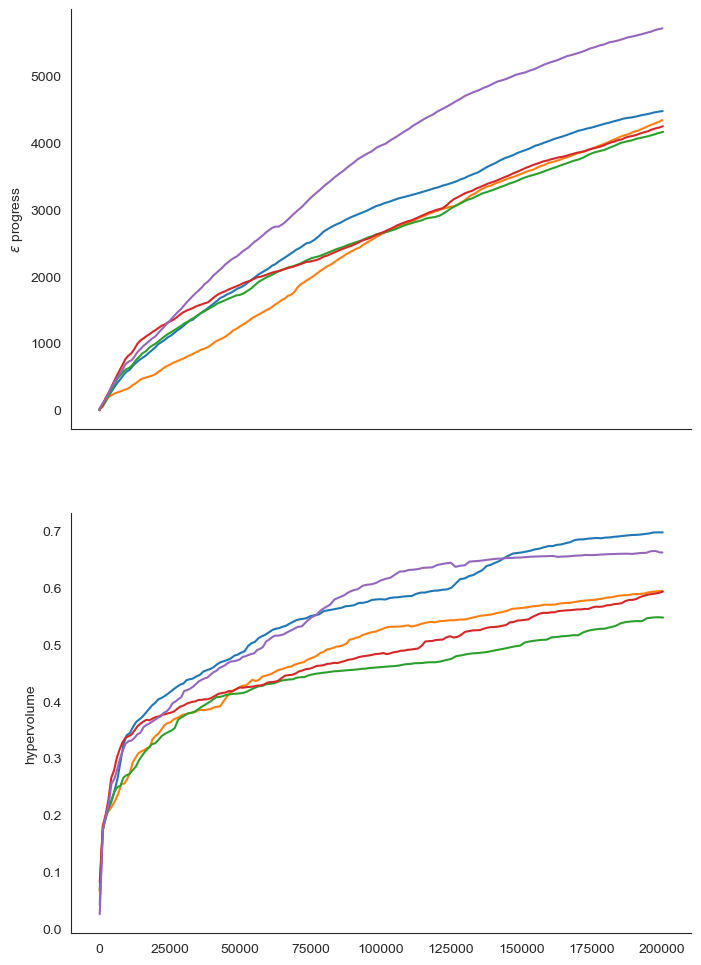

It took 0:09:38.727097 time to do 98527 nfes


In [283]:
# Visualize convergence metrics
sns.set_style("white")
fig, axes = plt.subplots(nrows=2, figsize=(8, 12), sharex=True)

ax1, ax2 = axes
import matplotlib.pyplot as plt

for metrics, convergence in zip(metrics_by_seed, convergences):
    #plt.rcParams["font.family"] = "sans-serif"
    ax1.plot(convergence.nfe, convergence.epsilon_progress)
    ax1.set_ylabel("$\epsilon$ progress")    
    
    ax2.plot(metrics.nfe, metrics.hypervolume)
    ax2.set_ylabel("hypervolume")
    
sns.despine(fig)


plt.show()

after = datetime.now()
print(f"It took {after - before} time to do {nfe} nfes")

In [16]:
# The following methods of calculating the hv are used for all the cases 

# Load the merged results
df = pd.read_csv("merged_results.csv")
cwd = os.getcwd()

column_names = ['Hydropower', 'Environment', 'Irrigation']
df_bc = df[column_names]

#Save the worst solutions for the normalization for the hypervolume calculation
worst_hyd = df_bc.Hydropower.max()
worst_irr = df_bc.Irrigation.max()
worst_env = df_bc.Environment.max()

worst_list = []
worst_list.append(worst_hyd)
worst_list.append(worst_env)
worst_list.append(worst_irr)

worst_array = np.asarray(worst_list)
worst_array

array([1.81990276e+01, 3.59105332e+06, 3.99413457e+00])

In [17]:
print(worst_list)

[18.1990275868451, 3591053.3164526736, 3.994134565562855]


In [18]:
def alternative_load_archives(filename):
    archives = {}
    norm_archives = {}
    with tarfile.open(os.path.abspath(filename)) as fh:
        for entry in fh.getmembers():
            if entry.name.endswith("csv"):
                key = entry.name.split("/")[1][:-4]
                #print(entry.name)
                df = pd.read_csv(fh.extractfile(entry), usecols = column_names)#, index_col=0
                norm_df = pd.DataFrame()
                norm_df['Hydropower']=(df['Hydropower']-best_hyd)/(worst_hyd-best_hyd)
                norm_df['Environment']=(df['Environment']-best_env)/(worst_env-best_env)
                norm_df['Irrigation']=(df['Irrigation']-best_irr)/(worst_irr-best_irr)
                if not df.empty:
                    archives[int(key)] = df
                if not norm_df.empty:
                    norm_archives[int(key)] = norm_df
                    #print(df)
    return archives, norm_archives

ArchiveLogger.load_archives = alternative_load_archives

norm_worst_array = np.ascontiguousarray([1.0, 1.0, 1.0])

In [20]:
# Create dict
hvs_dict, norm_hvs_dict = process_archives(seeds, worst_array, norm_worst_array)

# Save dictionary to a pickle file
with open('hv_bc_200.pkl', 'wb') as pickle_file:
    pickle.dump(hvs_dict, pickle_file)
    
hvs_dicts = [hvs_dict]

# Iterate through dictionaries and plot lines
for i, hvs_dict in enumerate(hvs_dicts, start=1):
    for seed, values in hvs_dict.items():
        x = list(values.keys()) 
        y = list(values.values()) 
        plt.plot(x, y, label=f'Seed {seed}')

plt.title('Hypervolume base case')
plt.legend()

print(os.getcwd())
relative_path = '../../plots'
filename = f'basecase_{run_comment}_hv.png'

plt.savefig(os.path.join(relative_path, filename))

plt.show()


NameError: name 'best_hyd' is not defined

In [ ]:
os.getcwd()

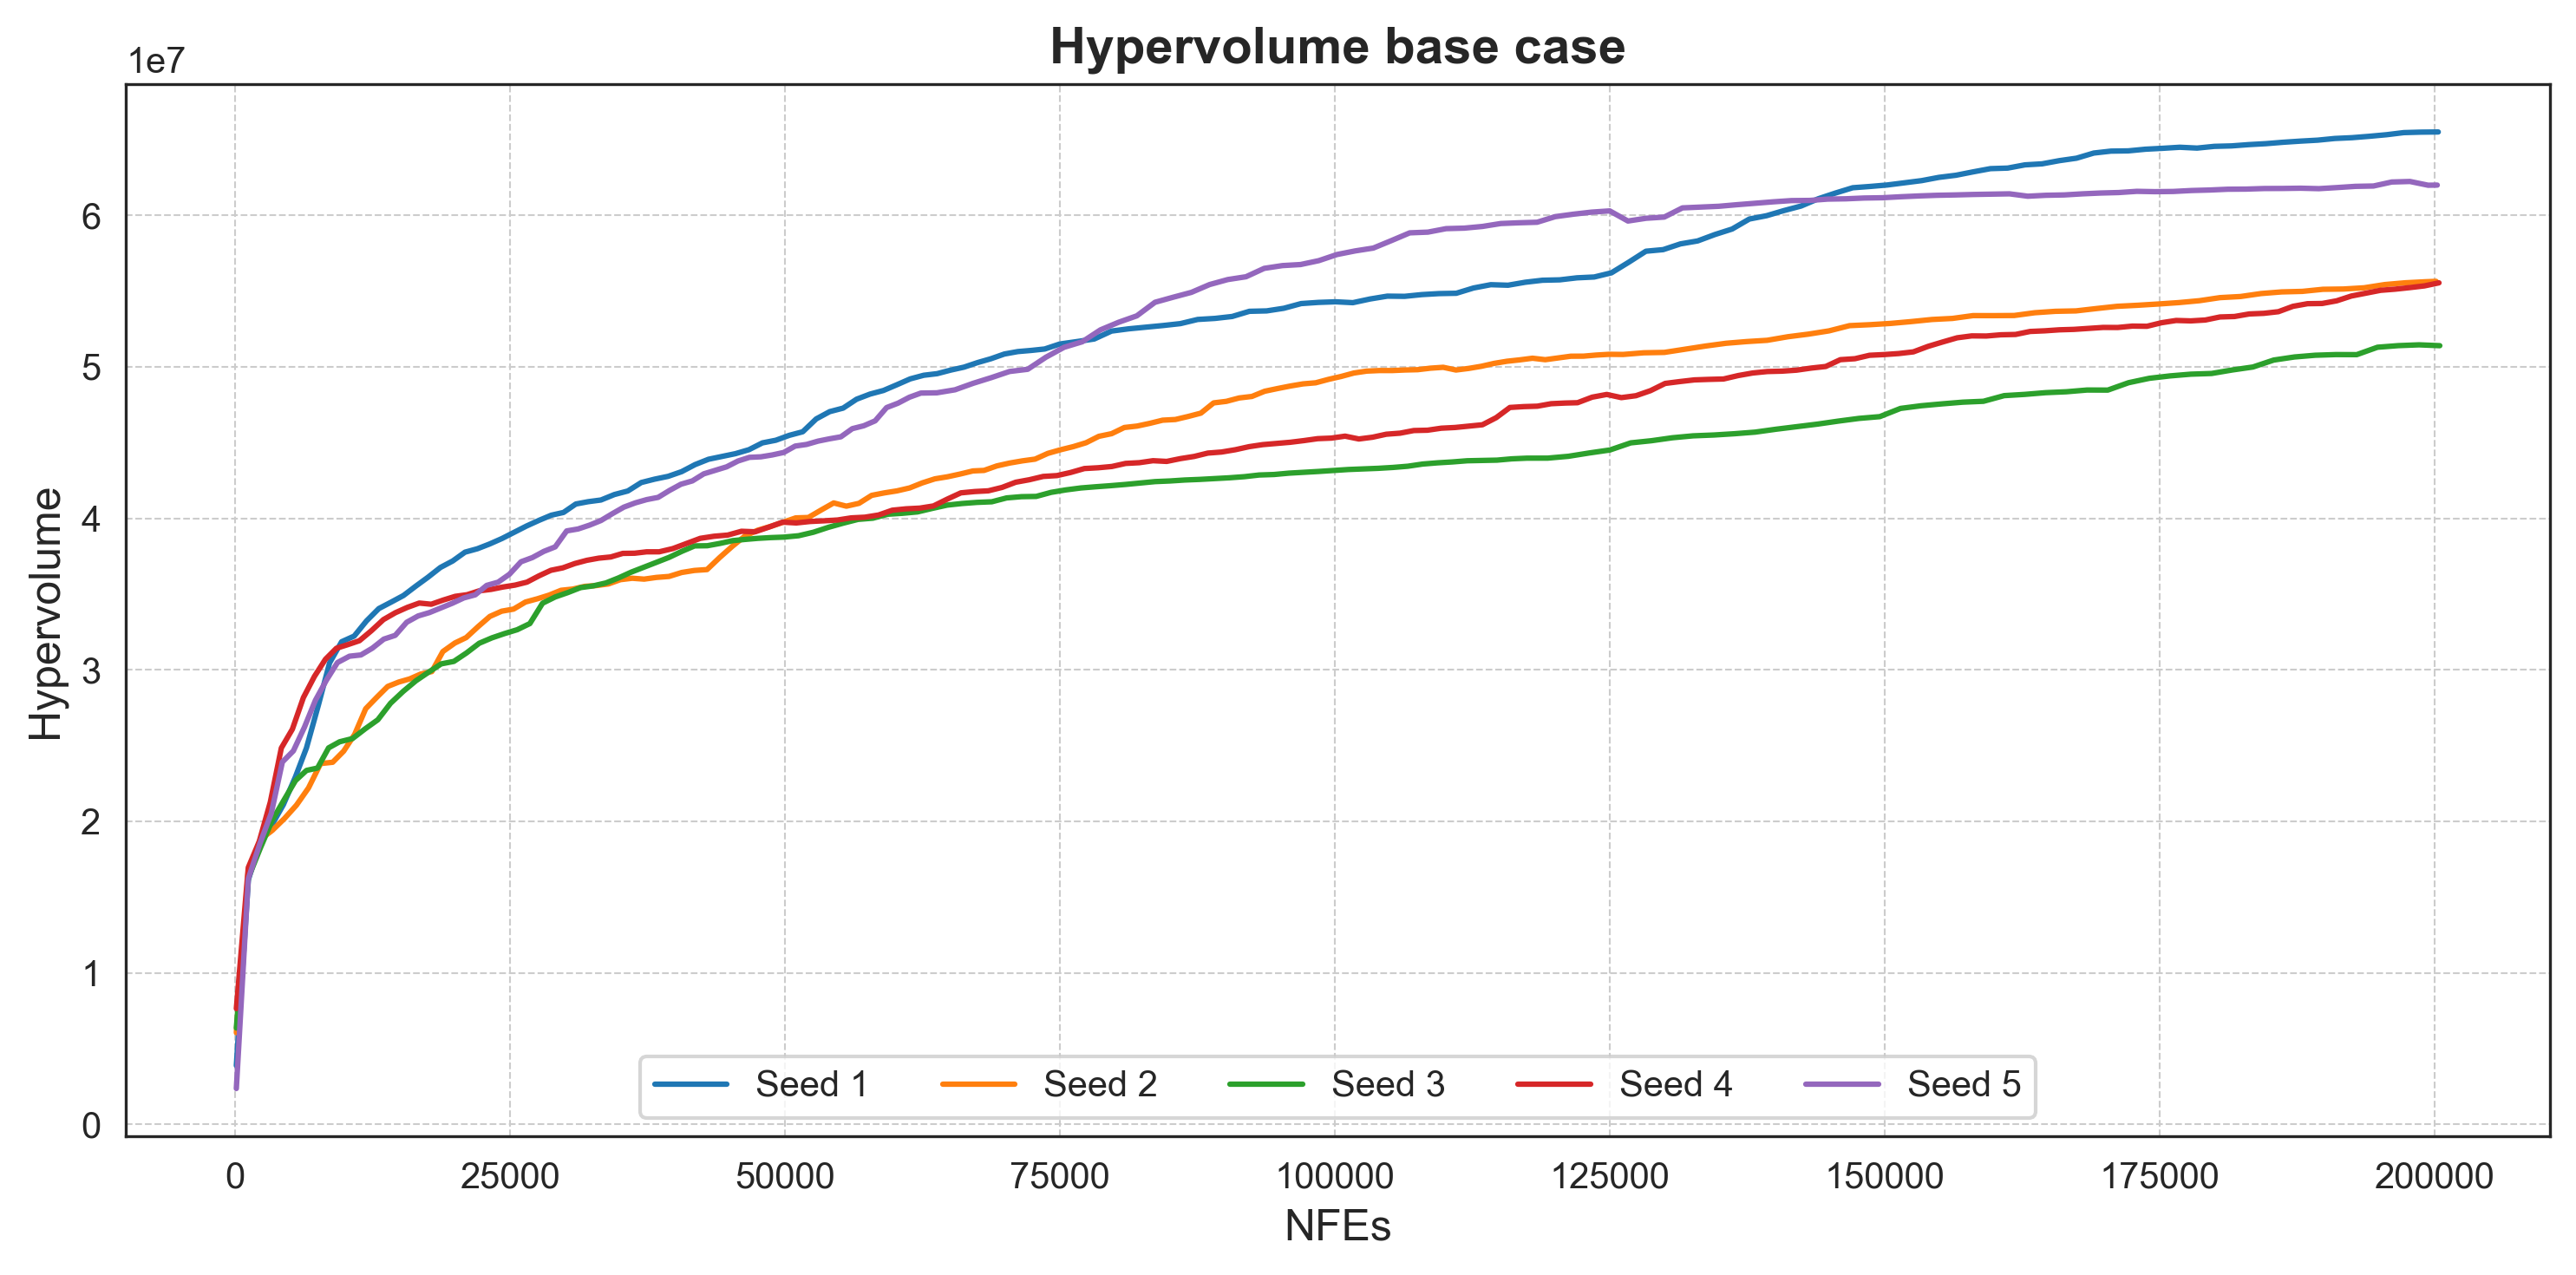

C:\Users\whitl\OneDrive\Documenten\MASTER\Year 2\THESIS\16.02.22.Multiobjective\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\ZambeziSmashPython\runs\BC_BC_pseudo_200000nfe_5seed


In [289]:
os.chdir('../BC_BC_pseudo_200000nfe_5seed')
with open('hv_bc_200.pkl', 'rb') as pickle_file:
    hvs_dict = pickle.load(pickle_file)

hvs_dicts = [hvs_dict]

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)

# Iterate through dictionaries and plot lines
for i, hvs_dict in enumerate(hvs_dicts, start=1):
    for seed, values in hvs_dict.items():
        x = list(values.keys())
        y = list(values.values())
        ax.plot(x, y, label=f'Seed {seed}')

# Customize the plot using ax
ax.set_title('Hypervolume Base Case (3 objectives)', fontsize=14, fontweight='bold')
plt.xlabel('NFE', fontsize=12)
plt.ylabel('Hypervolume', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(['Seed 1', 'Seed 2', 'Seed 3', 'Seed 4', 'Seed 5'], loc='lower center', fontsize=10, ncol=5)
plt.tight_layout()

# Save the plot
relative_path = '../../plots'
filename = f'hv_bc_june.png'
fig.savefig(os.path.join(relative_path, filename), bbox_inches='tight')

plt.show()

print(os.getcwd())

# IRRIGATION CASE

In [291]:
if not os.path.exists("../src"):
    os.chdir("../../src")
else:
    os.chdir('../src')
os.getcwd()

from model_zambezi_OPT_irr import ModelZambezi

ZambeziProblem = ModelZambezi()

def model_wrapper(**kwargs):
    input = [kwargs['v' + str(i)] for i in range(len(kwargs))]
    Hydropower, Environment, Irrigation, Irrigation2, Irrigation3, Irrigation4, Irrigation5, Irrigation6, Irrigation7, \
        Irrigation8, Irrigation9 = tuple(ZambeziProblem.evaluate(np.array(input)))
    return Hydropower, Environment, Irrigation, Irrigation2, Irrigation3, Irrigation4, Irrigation5, Irrigation6, \
        Irrigation7, Irrigation8, Irrigation9
# specify model
model = Model('zambeziproblem', function=model_wrapper)

# levers
model.levers = [RealParameter('v' + str(i), -1, 1) for i in range(ZambeziProblem.Nvar)]

# specify outcomes
model.outcomes = [ScalarOutcome('Hydropower', ScalarOutcome.MINIMIZE),  # Minimize, because deficits
                  ScalarOutcome('Environment', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation2', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation3', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation4', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation5', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation6', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation7', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation8', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation9', ScalarOutcome.MINIMIZE),
                  ]
#Problem definitionv
problem = to_problem(model, searchover="levers")

Run definition

In [293]:
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\src'

In [294]:
if not os.path.exists("../src"):
    os.chdir("../../src")
else:
    os.chdir('../src')
os.getcwd()


nfe = 200000 #
seeds = 5
run_comment = 'new_pseudo'
run_label = f"IR_{run_comment}_{nfe}nfe_{seeds}seed" #{run_comment}_

os.chdir(f'../runs/{run_label}')
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\runs\\IR_new_pseudo_200000nfe_5seed'

Change the load archives method of the ArchiveLogger class

In [296]:
# Get the worst values 

# Load the merged results
df = pd.read_csv("merged_results.csv")

column_names = ['Hydropower', 'Environment', 'Irrigation', 'Irrigation2', 'Irrigation3', 'Irrigation4', 'Irrigation5', 'Irrigation6', \
        'Irrigation7', 'Irrigation8', 'Irrigation9']

df_irr = df[column_names]

# Save the worst solutions as a reference for the hypervolume calculation
worst_hyd = df_irr.Hydropower.max()
worst_irr = df_irr.Irrigation.max()
worst_env = df_irr.Environment.max()
worst_irr2 = df_irr.Irrigation2.max()
worst_irr3 = df_irr.Irrigation3.max()
worst_irr4 = df_irr.Irrigation4.max()
worst_irr5 = df_irr.Irrigation5.max()
worst_irr6 = df_irr.Irrigation6.max()
worst_irr7 = df_irr.Irrigation7.max()
worst_irr8 = df_irr.Irrigation8.max()
worst_irr9 = df_irr.Irrigation9.max()

worst_list = []
worst_list.append(worst_hyd)
worst_list.append(worst_env)
worst_list.append(worst_irr)
worst_list.append(worst_irr2)
worst_list.append(worst_irr3)
worst_list.append(worst_irr4)
worst_list.append(worst_irr5)
worst_list.append(worst_irr6)
worst_list.append(worst_irr7)
worst_list.append(worst_irr8)
worst_list.append(worst_irr9)

worst_array = np.asarray(worst_list)
worst_array

array([2.37362470e+01, 3.96211176e+06, 4.56199569e+00, 7.97934733e-01,
       8.16084010e-01, 7.48961481e-01, 5.11218744e-01, 6.81394090e-01,
       5.00000000e-01, 9.16666667e-01, 7.82531372e-01])

In [297]:
def alternative_load_archives(filename):
    archives = {}
    norm_archives = {}
    with tarfile.open(os.path.abspath(filename)) as fh:
        for entry in fh.getmembers():
            if entry.name.endswith("csv"):
                key = entry.name.split("/")[1][:-4]
                #print(entry.name)
                df = pd.read_csv(fh.extractfile(entry), usecols = column_names)#, index_col=0
                norm_df = pd.DataFrame()
                norm_df['Hydropower']=(df['Hydropower']-best_hyd)/(worst_hyd-best_hyd)
                norm_df['Environment']=(df['Environment']-best_env)/(worst_env-best_env)
                norm_df['Irrigation']=(df['Irrigation']-best_irr)/(worst_irr-best_irr)
                norm_df['Irrigation2']=(df['Irrigation2']-best_irr2)/(worst_irr2-best_irr2)
                norm_df['Irrigation3']=(df['Irrigation3']-best_irr3)/(worst_irr3-best_irr3)
                norm_df['Irrigation4']=(df['Irrigation4']-best_irr4)/(worst_irr4-best_irr4)
                norm_df['Irrigation5']=(df['Irrigation5']-best_irr5)/(worst_irr5-best_irr5)
                norm_df['Irrigation6']=(df['Irrigation6']-best_irr6)/(worst_irr6-best_irr6)
                norm_df['Irrigation7']=(df['Irrigation7']-best_irr7)/(worst_irr7-best_irr7)
                norm_df['Irrigation8']=(df['Irrigation8']-best_irr8)/(worst_irr8-best_irr8)
                norm_df['Irrigation9']=(df['Irrigation9']-best_irr9)/(worst_irr9-best_irr9)
                if not df.empty:
                    archives[int(key)] = df
                if not norm_df.empty:
                    norm_archives[int(key)] = norm_df
                    #print(df)
    return archives, norm_archives

ArchiveLogger.load_archives = alternative_load_archives

#worst_array = np.ascontiguousarray([30.17937625072075, 4214070.319504687, 4.074369590148062])
norm_worst_array = np.ascontiguousarray([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

C:\Users\whitl\OneDrive\Documenten\MASTER\Year 2\THESIS\16.02.22.Multiobjective\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\ZambeziSmashPython\runs\IR_new_pseudo_200000nfe_5seed


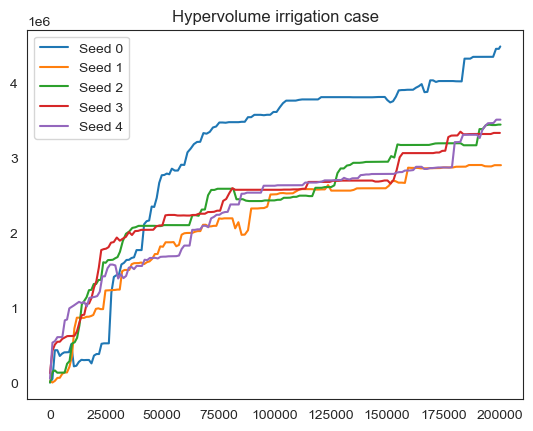

In [298]:
hvs_dict, norm_hvs_dict = process_archives(seeds, worst_array, norm_worst_array)

# Save dictionary to a pickle file
with open('hv_ir_200.pkl', 'wb') as pickle_file:
    pickle.dump(hvs_dict, pickle_file)
    
hvs_dicts = [hvs_dict]

# Iterate through dictionaries and plot lines
for i, hvs_dict in enumerate(hvs_dicts, start=1):
    for seed, values in hvs_dict.items():
        x = list(values.keys()) 
        y = list(values.values())  
        plt.plot(x, y, label=f'Seed {seed}')

plt.title('Hypervolume irrigation case')
plt.legend()

print(os.getcwd())
relative_path = '../../plots'
filename = f'irr_{run_comment}_hv.png'  

plt.savefig(os.path.join(relative_path, filename))

plt.show()

# IRRIGATION 1 million nfes
5 individual runs, each with one seed. Later combined

In [300]:
if not os.path.exists("../src"):
    os.chdir("../../src")
else:
    os.chdir('../src')
os.getcwd()

from model_zambezi_OPT_irr import ModelZambezi

ZambeziProblem = ModelZambezi()

def model_wrapper(**kwargs):
    input = [kwargs['v' + str(i)] for i in range(len(kwargs))]
    Hydropower, Environment, Irrigation, Irrigation2, Irrigation3, Irrigation4, Irrigation5, Irrigation6, Irrigation7, \
        Irrigation8, Irrigation9 = tuple(ZambeziProblem.evaluate(np.array(input)))
    return Hydropower, Environment, Irrigation, Irrigation2, Irrigation3, Irrigation4, Irrigation5, Irrigation6, \
        Irrigation7, Irrigation8, Irrigation9
# specify model
model = Model('zambeziproblem', function=model_wrapper)

# levers
model.levers = [RealParameter('v' + str(i), -1, 1) for i in range(ZambeziProblem.Nvar)]

# specify outcomes
model.outcomes = [ScalarOutcome('Hydropower', ScalarOutcome.MINIMIZE),  # Minimize, because deficits
                  ScalarOutcome('Environment', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation2', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation3', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation4', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation5', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation6', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation7', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation8', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation9', ScalarOutcome.MINIMIZE),
                  ]
#Problem definitionv
problem = to_problem(model, searchover="levers")


def alternative_load_archives_ir(filename):
    archives = {}
    norm_archives = {}
    with tarfile.open(os.path.abspath(filename)) as fh:
        for entry in fh.getmembers():
            if entry.name.endswith("csv"):
                key = entry.name.split("/")[1][:-4]
                #print(entry.name)
                df = pd.read_csv(fh.extractfile(entry), usecols = column_names)#, index_col=0
                norm_df = pd.DataFrame()
                norm_df['Hydropower']=(df['Hydropower']-best_hyd)/(worst_hyd-best_hyd)
                norm_df['Environment']=(df['Environment']-best_env)/(worst_env-best_env)
                norm_df['Irrigation']=(df['Irrigation']-best_irr)/(worst_irr-best_irr)
                norm_df['Irrigation2']=(df['Irrigation2']-best_irr2)/(worst_irr2-best_irr2)
                norm_df['Irrigation3']=(df['Irrigation3']-best_irr3)/(worst_irr3-best_irr3)
                norm_df['Irrigation4']=(df['Irrigation4']-best_irr4)/(worst_irr4-best_irr4)
                norm_df['Irrigation5']=(df['Irrigation5']-best_irr5)/(worst_irr5-best_irr5)
                norm_df['Irrigation6']=(df['Irrigation6']-best_irr6)/(worst_irr6-best_irr6)
                norm_df['Irrigation7']=(df['Irrigation7']-best_irr7)/(worst_irr7-best_irr7)
                norm_df['Irrigation8']=(df['Irrigation8']-best_irr8)/(worst_irr8-best_irr8)
                norm_df['Irrigation9']=(df['Irrigation9']-best_irr9)/(worst_irr9-best_irr9)
                if not df.empty:
                    archives[int(key)] = df
                if not norm_df.empty:
                    norm_archives[int(key)] = norm_df
                    #print(df)
    return archives, norm_archives


Run definition

In [302]:
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\src'

### First seed 

In [304]:
if not os.path.exists("../src"):
    os.chdir("../../src")
else:
    os.chdir('../src')
os.getcwd()


nfe = 1000000 #
seeds = 1
run_comment = 'new_pseudo_1st_mln'
run_label = f"IR_{run_comment}_{nfe}nfe_{seeds}seed" #{run_comment}_

os.chdir(f'../runs/{run_label}')
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\runs\\IR_new_pseudo_1st_mln_1000000nfe_1seed'

In [305]:
# Get the worst values 

# Load the merged results
df = pd.read_csv("merged_results.csv")

column_names = ['Hydropower', 'Environment', 'Irrigation', 'Irrigation2', 'Irrigation3', 'Irrigation4', 'Irrigation5', 'Irrigation6', \
        'Irrigation7', 'Irrigation8', 'Irrigation9']

df_irr = df[column_names]

# Save the worst solutions as a reference for the hypervolume calculation
worst_hyd = df_irr.Hydropower.max()
worst_irr = df_irr.Irrigation.max()
worst_env = df_irr.Environment.max()
worst_irr2 = df_irr.Irrigation2.max()
worst_irr3 = df_irr.Irrigation3.max()
worst_irr4 = df_irr.Irrigation4.max()
worst_irr5 = df_irr.Irrigation5.max()
worst_irr6 = df_irr.Irrigation6.max()
worst_irr7 = df_irr.Irrigation7.max()
worst_irr8 = df_irr.Irrigation8.max()
worst_irr9 = df_irr.Irrigation9.max()

worst_list = []
worst_list.append(worst_hyd)
worst_list.append(worst_env)
worst_list.append(worst_irr)
worst_list.append(worst_irr2)
worst_list.append(worst_irr3)
worst_list.append(worst_irr4)
worst_list.append(worst_irr5)
worst_list.append(worst_irr6)
worst_list.append(worst_irr7)
worst_list.append(worst_irr8)
worst_list.append(worst_irr9)

worst_array = np.asarray(worst_list)
worst_array

array([2.49027755e+01, 4.66464366e+06, 4.84859935e+00, 7.99459737e-01,
       7.45422608e-01, 7.65087421e-01, 4.97781573e-01, 7.39006966e-01,
       5.00000000e-01, 9.14918745e-01, 7.70505356e-01])

In [306]:
def alternative_load_archives(filename):
    archives = {}
    norm_archives = {}
    with tarfile.open(os.path.abspath(filename)) as fh:
        for entry in fh.getmembers():
            if entry.name.endswith("csv"):
                key = entry.name.split("/")[1][:-4]
                #print(entry.name)
                df = pd.read_csv(fh.extractfile(entry), usecols = column_names)#, index_col=0
                norm_df = pd.DataFrame()
                norm_df['Hydropower']=(df['Hydropower']-best_hyd)/(worst_hyd-best_hyd)
                norm_df['Environment']=(df['Environment']-best_env)/(worst_env-best_env)
                norm_df['Irrigation']=(df['Irrigation']-best_irr)/(worst_irr-best_irr)
                norm_df['Irrigation2']=(df['Irrigation2']-best_irr2)/(worst_irr2-best_irr2)
                norm_df['Irrigation3']=(df['Irrigation3']-best_irr3)/(worst_irr3-best_irr3)
                norm_df['Irrigation4']=(df['Irrigation4']-best_irr4)/(worst_irr4-best_irr4)
                norm_df['Irrigation5']=(df['Irrigation5']-best_irr5)/(worst_irr5-best_irr5)
                norm_df['Irrigation6']=(df['Irrigation6']-best_irr6)/(worst_irr6-best_irr6)
                norm_df['Irrigation7']=(df['Irrigation7']-best_irr7)/(worst_irr7-best_irr7)
                norm_df['Irrigation8']=(df['Irrigation8']-best_irr8)/(worst_irr8-best_irr8)
                norm_df['Irrigation9']=(df['Irrigation9']-best_irr9)/(worst_irr9-best_irr9)
                if not df.empty:
                    archives[int(key)] = df
                if not norm_df.empty:
                    norm_archives[int(key)] = norm_df
                    #print(df)
    return archives, norm_archives

ArchiveLogger.load_archives = alternative_load_archives

#worst_array = np.ascontiguousarray([30.17937625072075, 4214070.319504687, 4.074369590148062])
norm_worst_array = np.ascontiguousarray([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

C:\Users\whitl\OneDrive\Documenten\MASTER\Year 2\THESIS\16.02.22.Multiobjective\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\ZambeziSmashPython\runs\IR_new_pseudo_1st_mln_1000000nfe_1seed


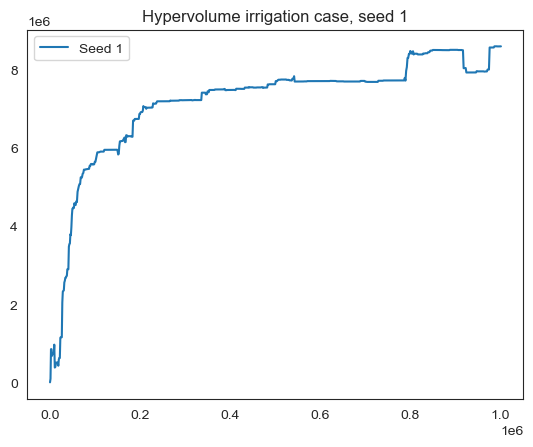

In [307]:
hvs_dict_1, norm_hvs_dict = process_archives(seeds, worst_array, norm_worst_array)

# Save dictionary to a pickle file
with open('hv_ir_mln_1.pkl', 'wb') as pickle_file:
    pickle.dump(hvs_dict_1, pickle_file)
    
hvs_dicts_1 = [hvs_dict_1]

# Iterate through dictionaries and plot lines
for i, hvs_dict_1 in enumerate(hvs_dicts_1, start=1):
    for seed, values in hvs_dict_1.items():
        x = list(values.keys())  
        y = list(values.values()) 
        plt.plot(x, y, label=f'Seed {seed+1}')

plt.title('Hypervolume irrigation case, seed 1')
plt.legend()

print(os.getcwd())
relative_path = '../../plots'
filename = f'irr_{run_comment}_hv.png'  # Assuming run_comment is defined

plt.savefig(os.path.join(relative_path, filename))


C:\Users\whitl\OneDrive\Documenten\MASTER\Year 2\THESIS\16.02.22.Multiobjective\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\ZambeziSmashPython\runs\IR_new_pseudo_1st_mln_1000000nfe_1seed


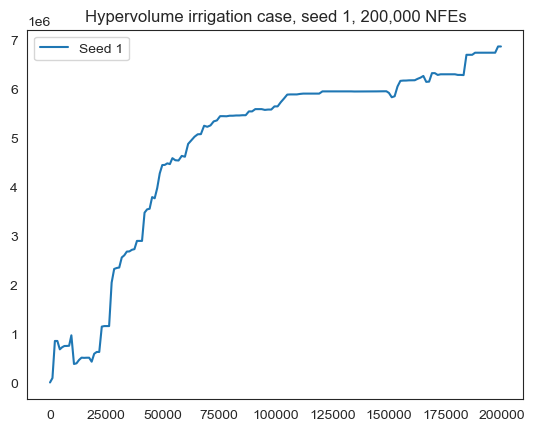

In [308]:
# Plot until 200,000 NFE's for comparison
for i, hvs_dict_1 in enumerate(hvs_dicts_1, start=1):
    for seed, values in hvs_dict_1.items():
        x = [key for key in values.keys() if key <= 200000]
        y = [values[key] for key in x]
        #x = list(values.keys())  
        #y = list(values.values()) 
        plt.plot(x, y, label=f'Seed {seed+1}')

plt.title('Hypervolume irrigation case, seed 1, 200,000 NFEs')
plt.legend()

print(os.getcwd())
relative_path = '../../plots'
filename = f'irr_{run_comment}_200k.png'  # Assuming run_comment is defined

plt.savefig(os.path.join(relative_path, filename))

plt.show()

### Second seed 

In [310]:
if not os.path.exists("../src"):
    os.chdir("../../src")
else:
    os.chdir('../src')
os.getcwd()


nfe = 1000000 #
seeds = 1
run_comment = 'new_pseudo_2nd_mln'
run_label = f"IR_{run_comment}_{nfe}nfe_{seeds}seed" #{run_comment}_

os.chdir(f'../runs/{run_label}')
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\runs\\IR_new_pseudo_2nd_mln_1000000nfe_1seed'

In [311]:
# Get the worst values 

# Load the merged results
df = pd.read_csv("merged_results.csv")

column_names = ['Hydropower', 'Environment', 'Irrigation', 'Irrigation2', 'Irrigation3', 'Irrigation4', 'Irrigation5', 'Irrigation6', \
        'Irrigation7', 'Irrigation8', 'Irrigation9']

df_irr = df[column_names]

#Save the worst solutions for the normalization for the hypervolume calculation
worst_hyd = df_irr.Hydropower.max()
worst_irr = df_irr.Irrigation.max()
worst_env = df_irr.Environment.max()
worst_irr2 = df_irr.Irrigation2.max()
worst_irr3 = df_irr.Irrigation3.max()
worst_irr4 = df_irr.Irrigation4.max()
worst_irr5 = df_irr.Irrigation5.max()
worst_irr6 = df_irr.Irrigation6.max()
worst_irr7 = df_irr.Irrigation7.max()
worst_irr8 = df_irr.Irrigation8.max()
worst_irr9 = df_irr.Irrigation9.max()

worst_list = []
worst_list.append(worst_hyd)
worst_list.append(worst_env)
worst_list.append(worst_irr)
worst_list.append(worst_irr2)
worst_list.append(worst_irr3)
worst_list.append(worst_irr4)
worst_list.append(worst_irr5)
worst_list.append(worst_irr6)
worst_list.append(worst_irr7)
worst_list.append(worst_irr8)
worst_list.append(worst_irr9)

worst_array = np.asarray(worst_list)
worst_array

array([2.65998319e+01, 4.84034134e+06, 5.09058038e+00, 7.84409523e-01,
       8.10477017e-01, 7.84376641e-01, 5.54443359e-01, 7.60145781e-01,
       5.00000000e-01, 9.12646484e-01, 7.81675577e-01])

In [312]:
def alternative_load_archives(filename):
    archives = {}
    norm_archives = {}
    with tarfile.open(os.path.abspath(filename)) as fh:
        for entry in fh.getmembers():
            if entry.name.endswith("csv"):
                key = entry.name.split("/")[1][:-4]
                #print(entry.name)
                df = pd.read_csv(fh.extractfile(entry), usecols = column_names)#, index_col=0
                norm_df = pd.DataFrame()
                norm_df['Hydropower']=(df['Hydropower']-best_hyd)/(worst_hyd-best_hyd)
                norm_df['Environment']=(df['Environment']-best_env)/(worst_env-best_env)
                norm_df['Irrigation']=(df['Irrigation']-best_irr)/(worst_irr-best_irr)
                norm_df['Irrigation2']=(df['Irrigation2']-best_irr2)/(worst_irr2-best_irr2)
                norm_df['Irrigation3']=(df['Irrigation3']-best_irr3)/(worst_irr3-best_irr3)
                norm_df['Irrigation4']=(df['Irrigation4']-best_irr4)/(worst_irr4-best_irr4)
                norm_df['Irrigation5']=(df['Irrigation5']-best_irr5)/(worst_irr5-best_irr5)
                norm_df['Irrigation6']=(df['Irrigation6']-best_irr6)/(worst_irr6-best_irr6)
                norm_df['Irrigation7']=(df['Irrigation7']-best_irr7)/(worst_irr7-best_irr7)
                norm_df['Irrigation8']=(df['Irrigation8']-best_irr8)/(worst_irr8-best_irr8)
                norm_df['Irrigation9']=(df['Irrigation9']-best_irr9)/(worst_irr9-best_irr9)
                if not df.empty:
                    archives[int(key)] = df
                if not norm_df.empty:
                    norm_archives[int(key)] = norm_df
                    #print(df)
    return archives, norm_archives

ArchiveLogger.load_archives = alternative_load_archives

#worst_array = np.ascontiguousarray([30.17937625072075, 4214070.319504687, 4.074369590148062])
norm_worst_array = np.ascontiguousarray([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

C:\Users\whitl\OneDrive\Documenten\MASTER\Year 2\THESIS\16.02.22.Multiobjective\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\ZambeziSmashPython\runs\IR_new_pseudo_2nd_mln_1000000nfe_1seed


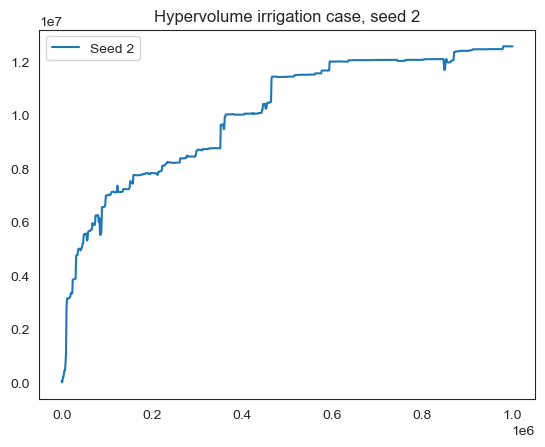

In [313]:
hvs_dict_2, norm_hvs_dict = process_archives(seeds, worst_array, norm_worst_array)

# Save dictionary to a pickle file
with open('hv_ir_mln_2.pkl', 'wb') as pickle_file:
    pickle.dump(hvs_dict_2, pickle_file)
    
hvs_dicts_2 = [hvs_dict_2]

# Iterate through dictionaries and plot lines
for i, hvs_dict_2 in enumerate(hvs_dicts_2, start=1):
    for seed, values in hvs_dict_2.items():
        x = list(values.keys())  
        y = list(values.values()) 
        plt.plot(x, y, label=f'Seed 2')

plt.title('Hypervolume irrigation case, seed 2')
plt.legend()

print(os.getcwd())
relative_path = '../../plots'
filename = f'irr_{run_comment}_hv.png'  # Assuming run_comment is defined

plt.savefig(os.path.join(relative_path, filename))


C:\Users\whitl\OneDrive\Documenten\MASTER\Year 2\THESIS\16.02.22.Multiobjective\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\ZambeziSmashPython\runs\IR_new_pseudo_2nd_mln_1000000nfe_1seed


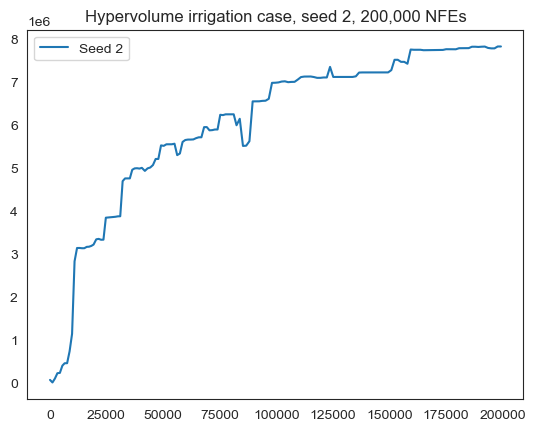

In [314]:
# Plot until 200,000 NFE's for comparison
for i, hvs_dict_2 in enumerate(hvs_dicts_2, start=1):
    for seed, values in hvs_dict_2.items():
        x = [key for key in values.keys() if key <= 200000]
        y = [values[key] for key in x]
        #x = list(values.keys())  
        #y = list(values.values()) 
        plt.plot(x, y, label=f'Seed 2')

plt.title('Hypervolume irrigation case, seed 2, 200,000 NFEs')
plt.legend()

print(os.getcwd())
relative_path = '../../plots'
filename = f'irr_{run_comment}_200k.png'  # Assuming run_comment is defined

plt.savefig(os.path.join(relative_path, filename))

plt.show()

### Third seed

In [316]:
if not os.path.exists("../src"):
    os.chdir("../../src")
else:
    os.chdir('../src')
os.getcwd()


nfe = 1000000 #
seeds = 1
run_comment = 'new_pseudo_3rd_mln'
run_label = f"IR_{run_comment}_{nfe}nfe_{seeds}seed" #{run_comment}_

os.chdir(f'../runs/{run_label}')
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\runs\\IR_new_pseudo_3rd_mln_1000000nfe_1seed'

In [317]:
# Get the worst values 

# Load the merged results
df = pd.read_csv("merged_results.csv")

column_names = ['Hydropower', 'Environment', 'Irrigation', 'Irrigation2', 'Irrigation3', 'Irrigation4', 'Irrigation5', 'Irrigation6', \
        'Irrigation7', 'Irrigation8', 'Irrigation9']

df_irr = df[column_names]

# Save the worst solutions as a reference for the hypervolume calculation
worst_hyd = df_irr.Hydropower.max()
worst_irr = df_irr.Irrigation.max()
worst_env = df_irr.Environment.max()
worst_irr2 = df_irr.Irrigation2.max()
worst_irr3 = df_irr.Irrigation3.max()
worst_irr4 = df_irr.Irrigation4.max()
worst_irr5 = df_irr.Irrigation5.max()
worst_irr6 = df_irr.Irrigation6.max()
worst_irr7 = df_irr.Irrigation7.max()
worst_irr8 = df_irr.Irrigation8.max()
worst_irr9 = df_irr.Irrigation9.max()

worst_list = []
worst_list.append(worst_hyd)
worst_list.append(worst_env)
worst_list.append(worst_irr)
worst_list.append(worst_irr2)
worst_list.append(worst_irr3)
worst_list.append(worst_irr4)
worst_list.append(worst_irr5)
worst_list.append(worst_irr6)
worst_list.append(worst_irr7)
worst_list.append(worst_irr8)
worst_list.append(worst_irr9)

worst_array = np.asarray(worst_list)
worst_array

array([2.45258669e+01, 3.80904733e+06, 4.68689239e+00, 7.87752346e-01,
       8.37754020e-01, 8.37718739e-01, 4.98093874e-01, 7.22352194e-01,
       5.00000000e-01, 9.14918745e-01, 7.96421867e-01])

In [318]:
def alternative_load_archives(filename):
    archives = {}
    norm_archives = {}
    with tarfile.open(os.path.abspath(filename)) as fh:
        for entry in fh.getmembers():
            if entry.name.endswith("csv"):
                key = entry.name.split("/")[1][:-4]
                #print(entry.name)
                df = pd.read_csv(fh.extractfile(entry), usecols = column_names)#, index_col=0
                norm_df = pd.DataFrame()
                norm_df['Hydropower']=(df['Hydropower']-best_hyd)/(worst_hyd-best_hyd)
                norm_df['Environment']=(df['Environment']-best_env)/(worst_env-best_env)
                norm_df['Irrigation']=(df['Irrigation']-best_irr)/(worst_irr-best_irr)
                norm_df['Irrigation2']=(df['Irrigation2']-best_irr2)/(worst_irr2-best_irr2)
                norm_df['Irrigation3']=(df['Irrigation3']-best_irr3)/(worst_irr3-best_irr3)
                norm_df['Irrigation4']=(df['Irrigation4']-best_irr4)/(worst_irr4-best_irr4)
                norm_df['Irrigation5']=(df['Irrigation5']-best_irr5)/(worst_irr5-best_irr5)
                norm_df['Irrigation6']=(df['Irrigation6']-best_irr6)/(worst_irr6-best_irr6)
                norm_df['Irrigation7']=(df['Irrigation7']-best_irr7)/(worst_irr7-best_irr7)
                norm_df['Irrigation8']=(df['Irrigation8']-best_irr8)/(worst_irr8-best_irr8)
                norm_df['Irrigation9']=(df['Irrigation9']-best_irr9)/(worst_irr9-best_irr9)
                if not df.empty:
                    archives[int(key)] = df
                if not norm_df.empty:
                    norm_archives[int(key)] = norm_df
                    #print(df)
    return archives, norm_archives

ArchiveLogger.load_archives = alternative_load_archives

#worst_array = np.ascontiguousarray([30.17937625072075, 4214070.319504687, 4.074369590148062])
norm_worst_array = np.ascontiguousarray([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

C:\Users\whitl\OneDrive\Documenten\MASTER\Year 2\THESIS\16.02.22.Multiobjective\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\ZambeziSmashPython\runs\IR_new_pseudo_3rd_mln_1000000nfe_1seed


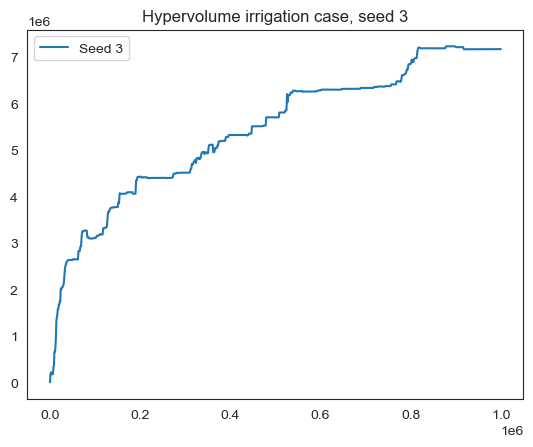

In [319]:
hvs_dict_3, norm_hvs_dict = process_archives(seeds, worst_array, norm_worst_array)

# Save dictionary to a pickle file
with open('hv_ir_mln_3.pkl', 'wb') as pickle_file:
    pickle.dump(hvs_dict_3, pickle_file)
    
hvs_dicts_3 = [hvs_dict_3]

# Iterate through dictionaries and plot lines
for i, hvs_dict_3 in enumerate(hvs_dicts_3, start=1):
    for seed, values in hvs_dict_3.items():
        x = list(values.keys())  
        y = list(values.values()) 
        plt.plot(x, y, label=f'Seed 3')

plt.title('Hypervolume irrigation case, seed 3')
plt.legend()

print(os.getcwd())
relative_path = '../../plots'
filename = f'irr_{run_comment}_hv.png'  # Assuming run_comment is defined

plt.savefig(os.path.join(relative_path, filename))


C:\Users\whitl\OneDrive\Documenten\MASTER\Year 2\THESIS\16.02.22.Multiobjective\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\ZambeziSmashPython\runs\IR_new_pseudo_3rd_mln_1000000nfe_1seed


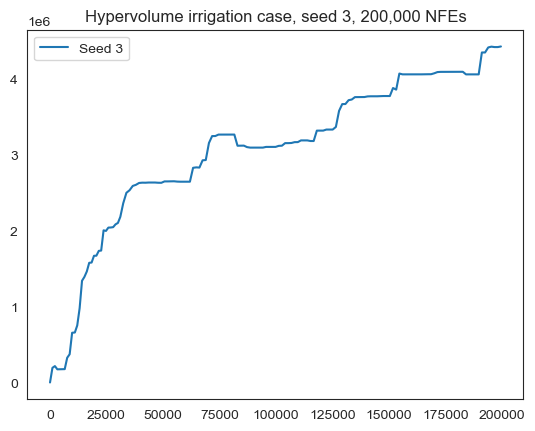

In [320]:
# Plot until 200,000 NFE's for comparison
for i, hvs_dict_3 in enumerate(hvs_dicts_3, start=1):
    for seed, values in hvs_dict_3.items():
        x = [key for key in values.keys() if key <= 200000]
        y = [values[key] for key in x]
        #x = list(values.keys())  
        #y = list(values.values()) 
        plt.plot(x, y, label=f'Seed 3')

plt.title('Hypervolume irrigation case, seed 3, 200,000 NFEs')
plt.legend()

print(os.getcwd())
relative_path = '../../plots'
filename = f'irr_{run_comment}_200k.png'  # Assuming run_comment is defined

plt.savefig(os.path.join(relative_path, filename))

plt.show()

### Fourth seed

In [322]:
if not os.path.exists("../src"):
    os.chdir("../../src")
else:
    os.chdir('../src')
os.getcwd()


nfe = 1000000 #
seeds = 1
run_comment = 'new_pseudo_4th_mln'
run_label = f"IR_{run_comment}_{nfe}nfe_{seeds}seed" #{run_comment}_

os.chdir(f'../runs/{run_label}')
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\runs\\IR_new_pseudo_4th_mln_1000000nfe_1seed'

In [323]:
# Get the worst values 

# Load the merged results
df = pd.read_csv("merged_results.csv")

column_names = ['Hydropower', 'Environment', 'Irrigation', 'Irrigation2', 'Irrigation3', 'Irrigation4', 'Irrigation5', 'Irrigation6', \
        'Irrigation7', 'Irrigation8', 'Irrigation9']

df_irr = df[column_names]

#Save the worst solutions for the normalization for the hypervolume calculation
worst_hyd = df_irr.Hydropower.max()
worst_irr = df_irr.Irrigation.max()
worst_env = df_irr.Environment.max()
worst_irr2 = df_irr.Irrigation2.max()
worst_irr3 = df_irr.Irrigation3.max()
worst_irr4 = df_irr.Irrigation4.max()
worst_irr5 = df_irr.Irrigation5.max()
worst_irr6 = df_irr.Irrigation6.max()
worst_irr7 = df_irr.Irrigation7.max()
worst_irr8 = df_irr.Irrigation8.max()
worst_irr9 = df_irr.Irrigation9.max()

worst_list = []
worst_list.append(worst_hyd)
worst_list.append(worst_env)
worst_list.append(worst_irr)
worst_list.append(worst_irr2)
worst_list.append(worst_irr3)
worst_list.append(worst_irr4)
worst_list.append(worst_irr5)
worst_list.append(worst_irr6)
worst_list.append(worst_irr7)
worst_list.append(worst_irr8)
worst_list.append(worst_irr9)

worst_array = np.asarray(worst_list)
worst_array

array([2.36817949e+01, 3.92692336e+06, 5.10026033e+00, 7.97934733e-01,
       7.09985892e-01, 7.40366599e-01, 5.04927708e-01, 6.41836790e-01,
       5.00000000e-01, 9.16666667e-01, 7.79984107e-01])

In [324]:
def alternative_load_archives(filename):
    archives = {}
    norm_archives = {}
    with tarfile.open(os.path.abspath(filename)) as fh:
        for entry in fh.getmembers():
            if entry.name.endswith("csv"):
                key = entry.name.split("/")[1][:-4]
                #print(entry.name)
                df = pd.read_csv(fh.extractfile(entry), usecols = column_names)#, index_col=0
                norm_df = pd.DataFrame()
                norm_df['Hydropower']=(df['Hydropower']-best_hyd)/(worst_hyd-best_hyd)
                norm_df['Environment']=(df['Environment']-best_env)/(worst_env-best_env)
                norm_df['Irrigation']=(df['Irrigation']-best_irr)/(worst_irr-best_irr)
                norm_df['Irrigation2']=(df['Irrigation2']-best_irr2)/(worst_irr2-best_irr2)
                norm_df['Irrigation3']=(df['Irrigation3']-best_irr3)/(worst_irr3-best_irr3)
                norm_df['Irrigation4']=(df['Irrigation4']-best_irr4)/(worst_irr4-best_irr4)
                norm_df['Irrigation5']=(df['Irrigation5']-best_irr5)/(worst_irr5-best_irr5)
                norm_df['Irrigation6']=(df['Irrigation6']-best_irr6)/(worst_irr6-best_irr6)
                norm_df['Irrigation7']=(df['Irrigation7']-best_irr7)/(worst_irr7-best_irr7)
                norm_df['Irrigation8']=(df['Irrigation8']-best_irr8)/(worst_irr8-best_irr8)
                norm_df['Irrigation9']=(df['Irrigation9']-best_irr9)/(worst_irr9-best_irr9)
                if not df.empty:
                    archives[int(key)] = df
                if not norm_df.empty:
                    norm_archives[int(key)] = norm_df
                    #print(df)
    return archives, norm_archives

ArchiveLogger.load_archives = alternative_load_archives

#worst_array = np.ascontiguousarray([30.17937625072075, 4214070.319504687, 4.074369590148062])
norm_worst_array = np.ascontiguousarray([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

C:\Users\whitl\OneDrive\Documenten\MASTER\Year 2\THESIS\16.02.22.Multiobjective\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\ZambeziSmashPython\runs\IR_new_pseudo_4th_mln_1000000nfe_1seed


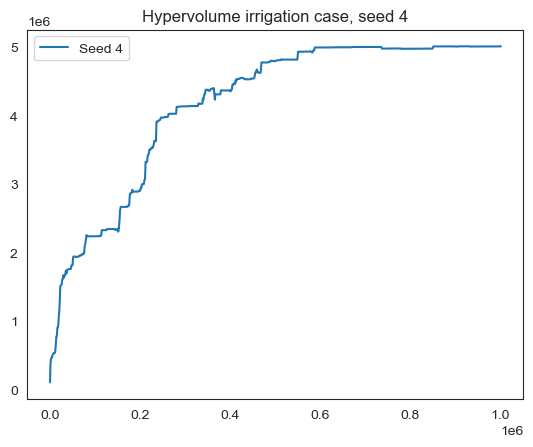

In [325]:
hvs_dict_4, norm_hvs_dict = process_archives(seeds, worst_array, norm_worst_array)

# Save dictionary to a pickle file
with open('hv_ir_mln_4.pkl', 'wb') as pickle_file:
    pickle.dump(hvs_dict_4, pickle_file)
hvs_dicts_4 = [hvs_dict_4]

# Iterate through dictionaries and plot lines
for i, hvs_dict_4 in enumerate(hvs_dicts_4, start=1):
    for seed, values in hvs_dict_4.items():
        x = list(values.keys())  
        y = list(values.values()) 
        plt.plot(x, y, label=f'Seed 4')

plt.title('Hypervolume irrigation case, seed 4')
plt.legend()

print(os.getcwd())
relative_path = '../../plots'
filename = f'irr_{run_comment}_hv.png'  # Assuming run_comment is defined

plt.savefig(os.path.join(relative_path, filename))


C:\Users\whitl\OneDrive\Documenten\MASTER\Year 2\THESIS\16.02.22.Multiobjective\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\ZambeziSmashPython\runs\IR_new_pseudo_4th_mln_1000000nfe_1seed


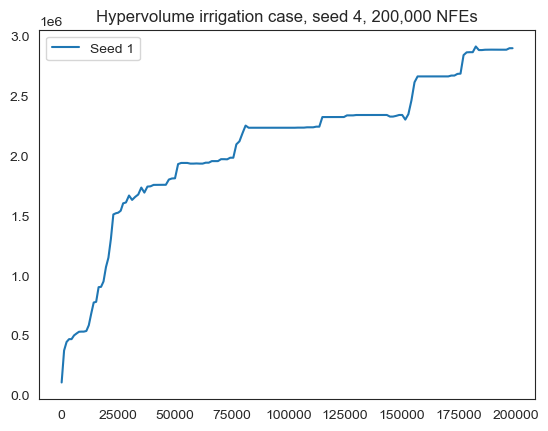

In [326]:
# Plot until 200,000 NFE's for comparison
for i, hvs_dict_4 in enumerate(hvs_dicts_4, start=1):
    for seed, values in hvs_dict_4.items():
        x = [key for key in values.keys() if key <= 200000]
        y = [values[key] for key in x]
        #x = list(values.keys())  
        #y = list(values.values()) 
        plt.plot(x, y, label=f'Seed {seed+1}')

plt.title('Hypervolume irrigation case, seed 4, 200,000 NFEs')
plt.legend()

print(os.getcwd())
relative_path = '../../plots'
filename = f'irr_{run_comment}_200k.png'  # Assuming run_comment is defined

plt.savefig(os.path.join(relative_path, filename))

plt.show()

### Fifth seed

In [328]:
if not os.path.exists("../src"):
    os.chdir("../../src")
else:
    os.chdir('../src')
os.getcwd()


nfe = 1000000 #
seeds = 1
run_comment = 'new_pseudo_5th_mln'
run_label = f"IR_{run_comment}_{nfe}nfe_{seeds}seed"

os.chdir(f'../runs/{run_label}')
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\runs\\IR_new_pseudo_5th_mln_1000000nfe_1seed'

In [329]:
# Get the worst values 

# Load the merged results
df = pd.read_csv("merged_results.csv")

column_names = ['Hydropower', 'Environment', 'Irrigation', 'Irrigation2', 'Irrigation3', 'Irrigation4', 'Irrigation5', 'Irrigation6', \
        'Irrigation7', 'Irrigation8', 'Irrigation9']

df_irr = df[column_names]

#Save the worst solutions for the normalization for the hypervolume calculation
worst_hyd = df_irr.Hydropower.max()
worst_irr = df_irr.Irrigation.max()
worst_env = df_irr.Environment.max()
worst_irr2 = df_irr.Irrigation2.max()
worst_irr3 = df_irr.Irrigation3.max()
worst_irr4 = df_irr.Irrigation4.max()
worst_irr5 = df_irr.Irrigation5.max()
worst_irr6 = df_irr.Irrigation6.max()
worst_irr7 = df_irr.Irrigation7.max()
worst_irr8 = df_irr.Irrigation8.max()
worst_irr9 = df_irr.Irrigation9.max()

worst_list = []
worst_list.append(worst_hyd)
worst_list.append(worst_env)
worst_list.append(worst_irr)
worst_list.append(worst_irr2)
worst_list.append(worst_irr3)
worst_list.append(worst_irr4)
worst_list.append(worst_irr5)
worst_list.append(worst_irr6)
worst_list.append(worst_irr7)
worst_list.append(worst_irr8)
worst_list.append(worst_irr9)

worst_array = np.asarray(worst_list)
worst_array

array([2.61962441e+01, 4.72270616e+06, 5.11094251e+00, 7.91908818e-01,
       8.33575131e-01, 7.71817315e-01, 5.01480660e-01, 7.65153964e-01,
       5.00000000e-01, 9.16666667e-01, 7.83103486e-01])

In [330]:
def alternative_load_archives(filename):
    archives = {}
    norm_archives = {}
    with tarfile.open(os.path.abspath(filename)) as fh:
        for entry in fh.getmembers():
            if entry.name.endswith("csv"):
                key = entry.name.split("/")[1][:-4]
                #print(entry.name)
                df = pd.read_csv(fh.extractfile(entry), usecols = column_names)#, index_col=0
                norm_df = pd.DataFrame()
                norm_df['Hydropower']=(df['Hydropower']-best_hyd)/(worst_hyd-best_hyd)
                norm_df['Environment']=(df['Environment']-best_env)/(worst_env-best_env)
                norm_df['Irrigation']=(df['Irrigation']-best_irr)/(worst_irr-best_irr)
                norm_df['Irrigation2']=(df['Irrigation2']-best_irr2)/(worst_irr2-best_irr2)
                norm_df['Irrigation3']=(df['Irrigation3']-best_irr3)/(worst_irr3-best_irr3)
                norm_df['Irrigation4']=(df['Irrigation4']-best_irr4)/(worst_irr4-best_irr4)
                norm_df['Irrigation5']=(df['Irrigation5']-best_irr5)/(worst_irr5-best_irr5)
                norm_df['Irrigation6']=(df['Irrigation6']-best_irr6)/(worst_irr6-best_irr6)
                norm_df['Irrigation7']=(df['Irrigation7']-best_irr7)/(worst_irr7-best_irr7)
                norm_df['Irrigation8']=(df['Irrigation8']-best_irr8)/(worst_irr8-best_irr8)
                norm_df['Irrigation9']=(df['Irrigation9']-best_irr9)/(worst_irr9-best_irr9)
                if not df.empty:
                    archives[int(key)] = df
                if not norm_df.empty:
                    norm_archives[int(key)] = norm_df
                    #print(df)
    return archives, norm_archives

ArchiveLogger.load_archives = alternative_load_archives

#worst_array = np.ascontiguousarray([30.17937625072075, 4214070.319504687, 4.074369590148062])
norm_worst_array = np.ascontiguousarray([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

C:\Users\whitl\OneDrive\Documenten\MASTER\Year 2\THESIS\16.02.22.Multiobjective\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\ZambeziSmashPython\runs\IR_new_pseudo_5th_mln_1000000nfe_1seed


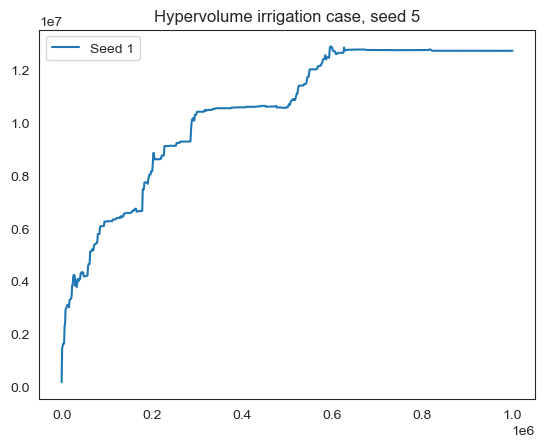

In [331]:
hvs_dict_5, norm_hvs_dict = process_archives(seeds, worst_array, norm_worst_array)

# Save dictionary to a pickle file
with open('hv_ir_mln_5.pkl', 'wb') as pickle_file:
    pickle.dump(hvs_dict_5, pickle_file)
    
hvs_dicts_5 = [hvs_dict_5]

# Iterate through dictionaries and plot lines
for i, hvs_dict_5 in enumerate(hvs_dicts_5, start=1):
    for seed, values in hvs_dict_5.items():
        x = list(values.keys())  
        y = list(values.values()) 
        plt.plot(x, y, label=f'Seed {seed+1}')

plt.title('Hypervolume irrigation case, seed 5')
plt.legend()

print(os.getcwd())
relative_path = '../../plots'
filename = f'irr_{run_comment}_hv.png'  # Assuming run_comment is defined

plt.savefig(os.path.join(relative_path, filename))


C:\Users\whitl\OneDrive\Documenten\MASTER\Year 2\THESIS\16.02.22.Multiobjective\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\ZambeziSmashPython\runs\IR_new_pseudo_5th_mln_1000000nfe_1seed


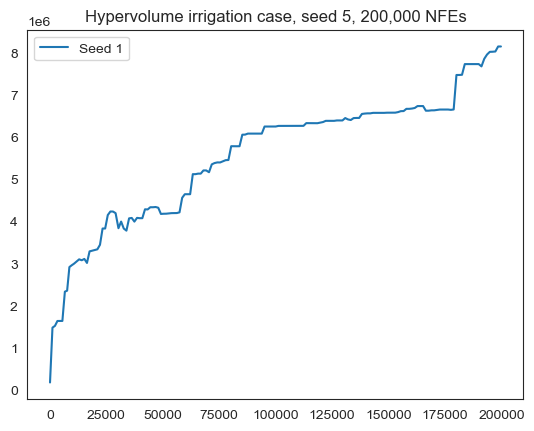

In [332]:
# Plot until 200,000 NFE's for comparison
for i, hvs_dict_5 in enumerate(hvs_dicts_5, start=1):
    for seed, values in hvs_dict_5.items():
        x = [key for key in values.keys() if key <= 200000]
        y = [values[key] for key in x]
        #x = list(values.keys())  
        #y = list(values.values()) 
        plt.plot(x, y, label=f'Seed {seed+1}')

plt.title('Hypervolume irrigation case, seed 5, 200,000 NFEs')
plt.legend()

print(os.getcwd())
relative_path = '../../plots'
filename = f'irr_{run_comment}_200k.png'  # Assuming run_comment is defined

plt.savefig(os.path.join(relative_path, filename))

plt.show()

In [333]:
# test
with open('hv_ir_mln_5.pkl', 'rb') as pickle_file:
    loaded_dict = pickle.load(pickle_file)

print(loaded_dict)

{0: {100: 166536.09134666997, 1185: 1470358.90187837, 2284: 1512468.774689094, 3378: 1628746.711084766, 4478: 1628746.711084766, 5576: 1629931.3955775676, 6676: 2325624.845114042, 7676: 2349847.0451800697, 8679: 2910726.2714689495, 9680: 2952588.9690234726, 10693: 2989997.1864001546, 11845: 3042020.015645556, 12997: 3094560.9941055076, 14151: 3072818.2115493803, 15307: 3104298.859219815, 16461: 3008889.8271971024, 17613: 3283765.223426867, 18764: 3299734.8723810986, 19918: 3313218.408283627, 21069: 3332767.6410312196, 22223: 3440666.1589505756, 23374: 3827671.5628117407, 24525: 3827751.441548198, 25679: 4147724.138948517, 26833: 4231675.774369046, 27988: 4231045.9565846715, 29137: 4193094.7740717735, 30405: 3834864.8947759727, 31582: 3992614.5220989115, 32758: 3826917.642458127, 33935: 3777025.671118421, 35111: 4069174.749302531, 36289: 4078693.8417153466, 37462: 3992021.2305849195, 38633: 4080320.080795477, 39807: 4073088.574454666, 40982: 4073103.03597848, 42159: 4284456.646731227, 4

In [334]:
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\runs\\IR_new_pseudo_5th_mln_1000000nfe_1seed'

## Combining the different seeds 

In [336]:
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\runs\\IR_new_pseudo_5th_mln_1000000nfe_1seed'

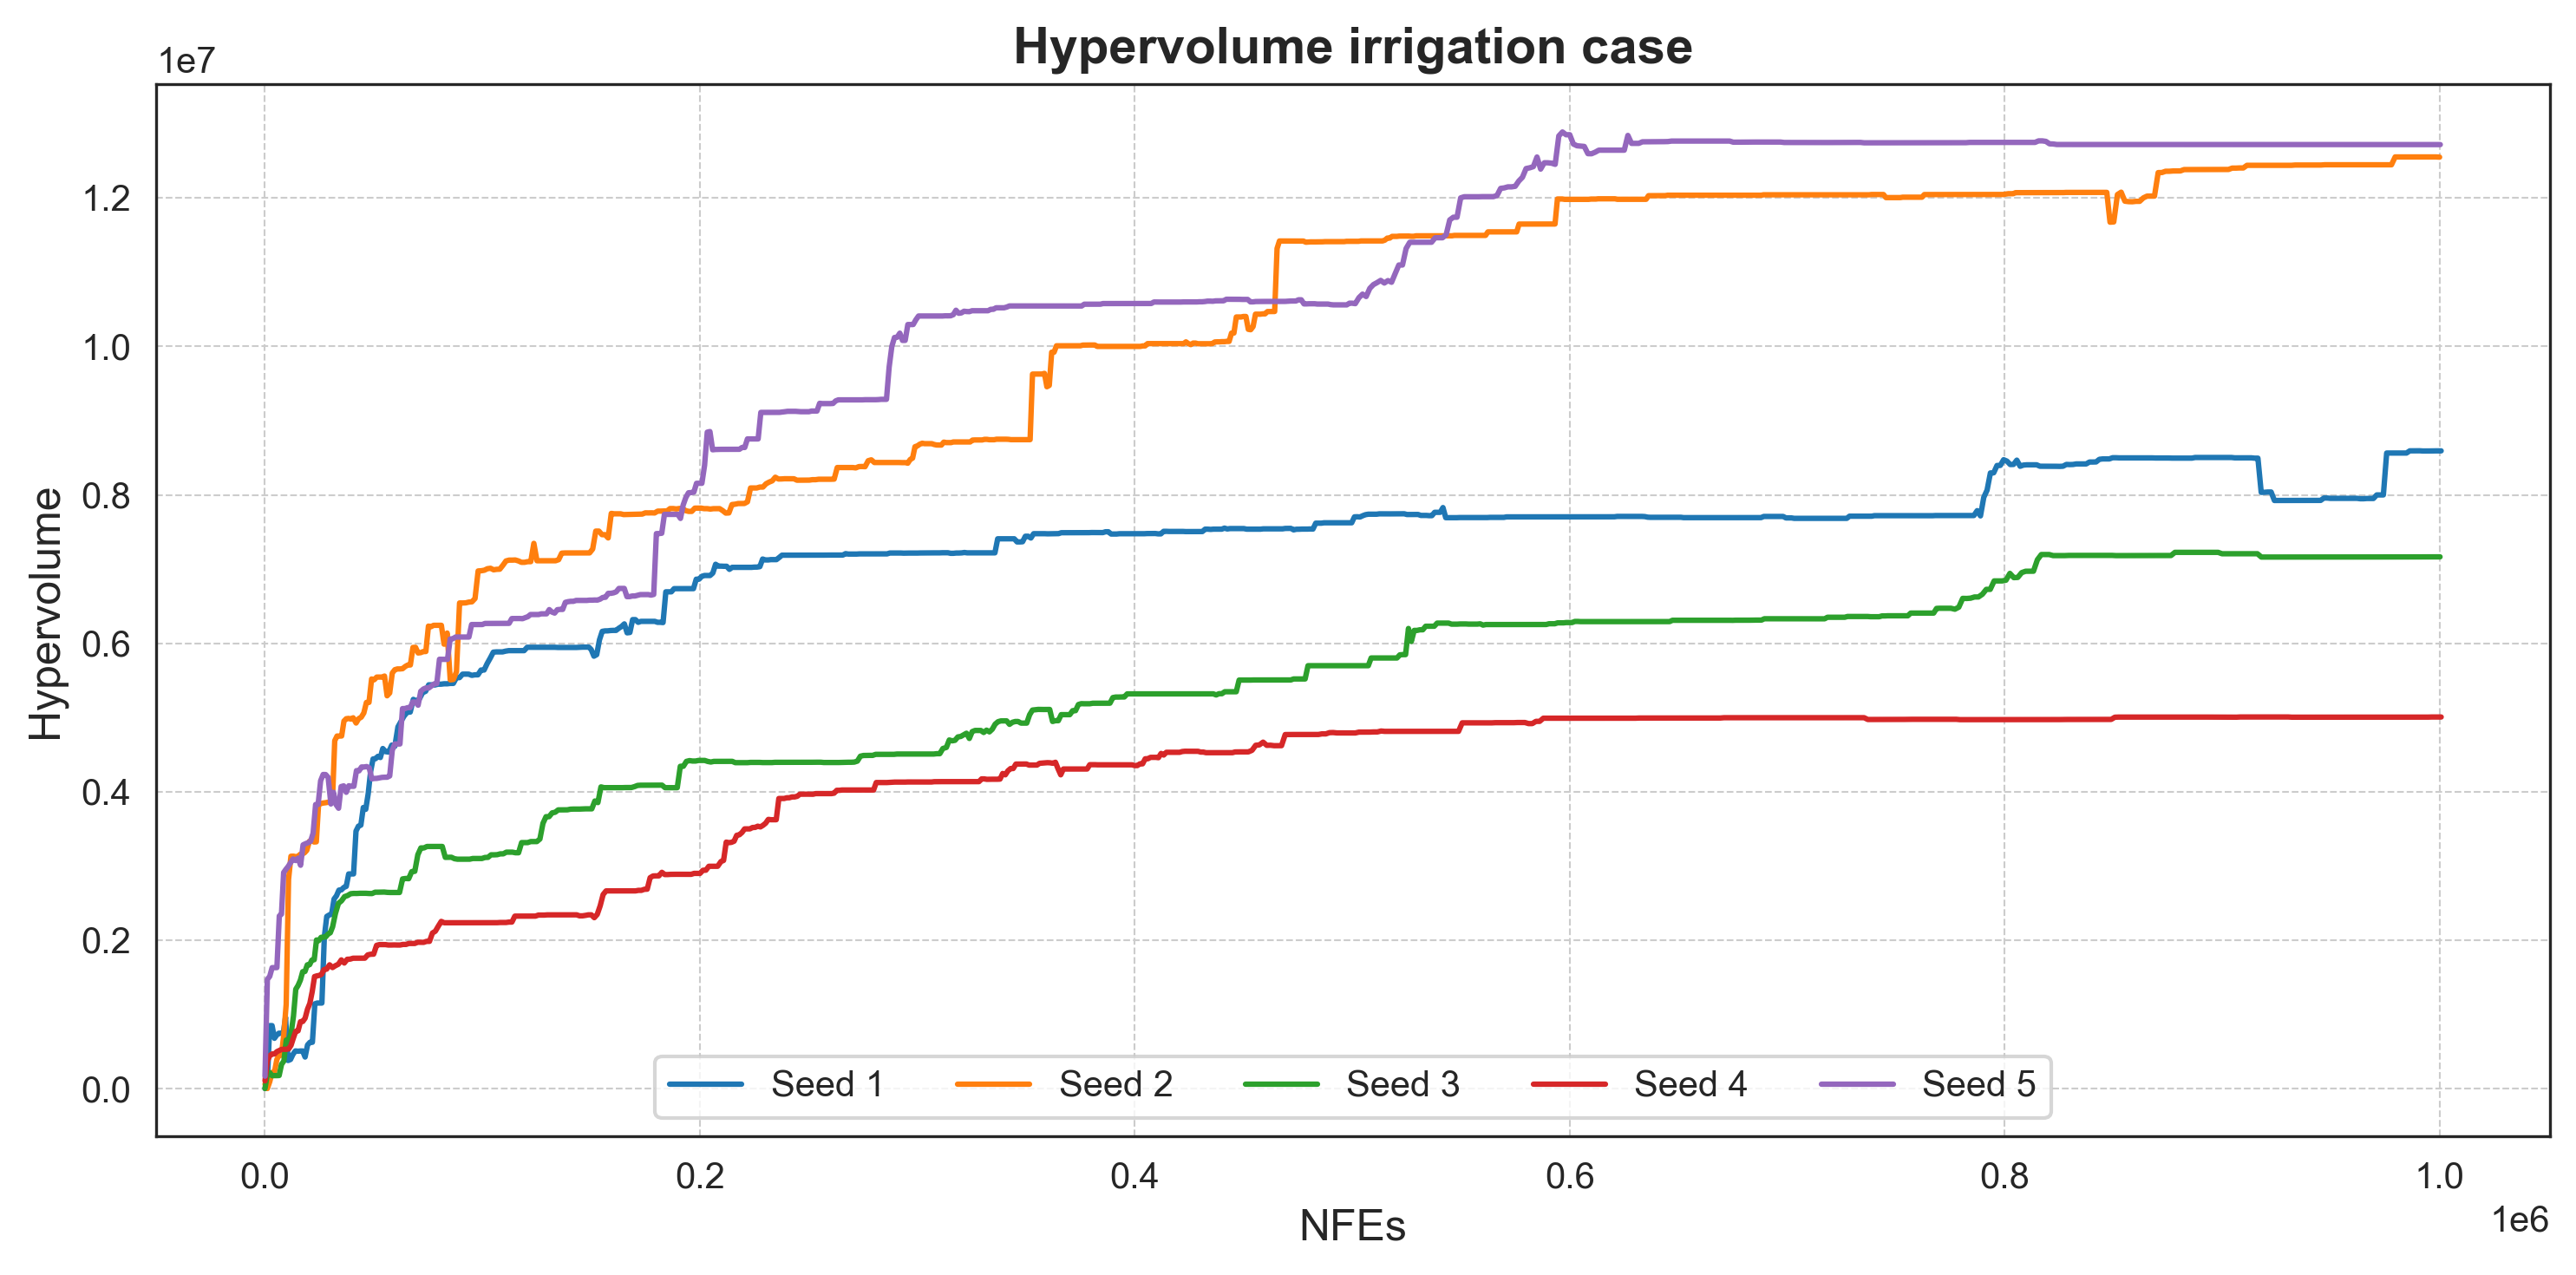

In [337]:
if os.path.exists("../../runs"):
    os.chdir("../../runs")
else:
    os.getcwd()


# Specify the paths to each pickle file
paths = [
    './IR_new_pseudo_1st_mln_1000000nfe_1seed/hv_ir_mln_1.pkl',
    './IR_new_pseudo_2nd_mln_1000000nfe_1seed/hv_ir_mln_2.pkl',
    './IR_new_pseudo_3rd_mln_1000000nfe_1seed/hv_ir_mln_3.pkl',
    './IR_new_pseudo_4th_mln_1000000nfe_1seed/hv_ir_mln_4.pkl',
    './IR_new_pseudo_5th_mln_1000000nfe_1seed/hv_ir_mln_5.pkl'
]

# Load the dictionaries from their respective files
hvs_dicts = []
for path in paths:
    with open(path, 'rb') as pickle_file:
        hvs_dicts.append(pickle.load(pickle_file))

# Assign to individual variables if needed
hvs_dict_1, hvs_dict_2, hvs_dict_3, hvs_dict_4, hvs_dict_5 = hvs_dicts

colors = ['blue', 'orange', 'green', 'red', 'purple']

# Create dataframes and seed labels
for i in [hvs_dict_1, hvs_dict_2, hvs_dict_3, hvs_dict_4, hvs_dict_5]:
    df1=pd.DataFrame.from_dict(hvs_dict_1)
    df1 = df1.rename(columns={0: "Seed 1"})
    df2=pd.DataFrame.from_dict(hvs_dict_2)
    df2 = df2.rename(columns={0: "Seed 2"})
    df3=pd.DataFrame.from_dict(hvs_dict_3)
    df3 = df3.rename(columns={0: "Seed 3"})    
    df4=pd.DataFrame.from_dict(hvs_dict_4)
    df4 = df4.rename(columns={0: "Seed 4"})    
    df5=pd.DataFrame.from_dict(hvs_dict_5)
    df5 = df5.rename(columns={0: "Seed 5"})
    
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)

df1.plot(ax=ax)
df2.plot(ax=ax)
df3.plot(ax=ax)
df4.plot(ax=ax)
df5.plot(ax=ax)

plt.title('Hypervolume irrigation case', fontsize=14, fontweight='bold')
plt.xlabel('NFEs', fontsize=12)
plt.ylabel('Hypervolume', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(['Seed 1', 'Seed 2', 'Seed 3', 'Seed 4', 'Seed 5'], loc='lower center', fontsize=10, ncol=5)
plt.tight_layout()

plt.show()

relative_path = '../plots'
filename = f'hv_irr_june_1mln_all_seeds.png'
fig.savefig(os.path.join(relative_path, filename), bbox_inches='tight')

# HYDROPOWER CASE

In [339]:
if not os.path.exists("../src"):
    os.chdir("../../src")
else:
    os.chdir('../src')
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\src'

In [340]:
from model_zambezi_OPT_hyd import ModelZambezi

ZambeziProblem = ModelZambezi()

def model_wrapper(**kwargs):
    input = [kwargs['v' + str(i)] for i in range(len(kwargs))]
    Hydropower, Environment, Irrigation, HydropowerITT, HydropowerKGU, HydropowerKA, HydropowerCB, HydropowerKGL = tuple(ZambeziProblem.evaluate(np.array(input)))
    return Hydropower, Environment, Irrigation, HydropowerITT, HydropowerKGU, HydropowerKA, HydropowerCB, HydropowerKGL
# specify model
model = Model('zambeziproblem', function=model_wrapper)

# levers
model.levers = [RealParameter('v' + str(i), -1, 1) for i in range(ZambeziProblem.Nvar)]

# specify outcomes
model.outcomes = [ScalarOutcome('Hydropower', ScalarOutcome.MINIMIZE),  # Minimize, because deficits
                  ScalarOutcome('Environment', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerITT', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerKGU', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerKA', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerCB', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerKGL', ScalarOutcome.MINIMIZE),
                  ]
# Define the new column names
column_names = ['Hydropower', 'Environment', 'Irrigation', 'HydropowerITT', 'HydropowerKGU', 'HydropowerKA', 'HydropowerCB', 'HydropowerKGL']


In [341]:
#Problem definition
problem = to_problem(model, searchover="levers")

Run definition

In [343]:
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\src'

In [344]:

nfe = 200000 #
seeds = 5
run_comment = 'pseudo'
run_label = f"HYD_{run_comment}_{nfe}nfe_{seeds}seed"

os.chdir(f'../runs/{run_label}')
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\runs\\HYD_pseudo_200000nfe_5seed'

Merge convergences 

In [346]:
# Load the merged results
df = pd.read_csv("merged_results.csv")

# Read the relevant columns from the CSV file
df_hyd = pd.read_csv("merged_results.csv", usecols=column_names)

# Find the index of the best solutions
index_best_hyd = df_hyd['Hydropower'].idxmin()
index_best_env = df_hyd['Environment'].idxmin()
index_best_irr = df_hyd['Irrigation'].idxmin()
index_best_hydITT = df_hyd['HydropowerITT'].idxmin()
index_best_hydKGU = df_hyd['HydropowerKGU'].idxmin()
index_best_hydKA = df_hyd['HydropowerKA'].idxmin()
index_best_hydCB = df_hyd['HydropowerCB'].idxmin()
index_best_hydKGL = df_hyd['HydropowerKGL'].idxmin()

# Create a dataframe without the objectives columns for the simulation
df_v = pd.read_csv("merged_results.csv", usecols=lambda x: x not in column_names )

# Extract the rows of the best solutions
best_hyd_row = df_v.loc[[index_best_hyd]]
best_env_row = df_v.loc[[index_best_env]]
best_irr_row = df_v.loc[[index_best_irr]]
best_hydITT_row = df_v.loc[[index_best_hydITT]]
best_hydKGU_row = df_v.loc[[index_best_hydKGU]]
best_hydKA_row = df_v.loc[[index_best_hydKA]]
best_hydCB_row = df_v.loc[[index_best_hydCB]]
best_hydKGL_row = df_v.loc[[index_best_hydKGL]]

#Save the best decisions for the simulation
cwd = os.getcwd()
path = f'../../decisions/hyd_{run_comment}/'
if not os.path.exists(path):
    os.makedirs(path)
os.chdir(path)
best_hyd_row.to_csv("decisions_best_hydro.txt", index=False, header=None, sep='\n')
best_env_row.to_csv("decisions_best_env.txt", index=False, header=None, sep='\n')
best_irr_row.to_csv("decisions_best_irr.txt", index=False, header=None, sep='\n')
best_hydITT_row.to_csv("decisions_best_hydITT.txt", index=False, header=None, sep='\n')
best_hydKGU_row.to_csv("decisions_best_hydKGU.txt", index=False, header=None, sep='\n')
best_hydKA_row.to_csv("decisions_best_hydKA.txt", index=False, header=None, sep='\n')
best_hydCB_row.to_csv("decisions_best_hydCB.txt", index=False, header=None, sep='\n')
best_hydKGL_row.to_csv("decisions_best_hydKGL.txt", index=False, header=None, sep='\n')
os.chdir(cwd)

# Save the worst solutions for the normalization for the hypervolume calculation
worst_hyd = df_hyd['Hydropower'].max()
worst_env = df_hyd['Environment'].max()
worst_irr = df_hyd['Irrigation'].max()
worst_hydITT = df_hyd['HydropowerITT'].max()
worst_hydKGU = df_hyd['HydropowerKGU'].max()
worst_hydKA = df_hyd['HydropowerKA'].max()
worst_hydCB = df_hyd['HydropowerCB'].max()
worst_hydKGL = df_hyd['HydropowerKGL'].max()

# Create a list of worst values
worst_list = [worst_hyd, worst_env, worst_irr, worst_hydITT, worst_hydKGU, worst_hydKA, worst_hydCB, worst_hydKGL]

# Convert the list to a numpy array
worst_array = np.asarray(worst_list)

best_hyd = df_hyd['Hydropower'].min()
best_irr = df_hyd['Irrigation'].min()
best_env = df_hyd['Environment'].min()
best_hydITT = df_hyd['HydropowerITT'].min()
best_hydKGU = df_hyd['HydropowerKGU'].min()
best_hydKA = df_hyd['HydropowerKA'].min()
best_hydCB = df_hyd['HydropowerCB'].min()
best_hydKGL = df_hyd['HydropowerKGL'].min()

best_list = [best_hydITT, best_hydKGU, best_hydKA, best_hydCB, best_hydKGL]

best_array = np.asarray(best_list)
best_array


array([0.1693175 , 0.39277484, 5.80527546, 3.68267484, 0.55233102])

In [347]:
print(worst_list)

[23.65008894035836, 3714319.217756417, 5.436040615002179, 0.5509900775261756, 2.891512597662931, 8.074609344439066, 10.587410682548986, 2.58500480059531]


In [348]:
def alternative_load_archives(filename):
    archives = {}
    norm_archives = {}
    with tarfile.open(os.path.abspath(filename)) as fh:
        for entry in fh.getmembers():
            if entry.name.endswith("csv"):
                key = entry.name.split("/")[1][:-4]
                #print(entry.name)
                df = pd.read_csv(fh.extractfile(entry), usecols = column_names)#, index_col=0
                #norm_df=(df-df.min())/(df.max()-df.min())
                norm_df = pd.DataFrame()
                norm_df['Hydropower']=(df['Hydropower']-best_hyd)/(worst_hyd-best_hyd)
                norm_df['Environment']=(df['Environment']-best_env)/(worst_env-best_env)
                norm_df['Irrigation']=(df['Irrigation']-best_irr)/(worst_irr-best_irr)
                norm_df['HydropowerITT'] = (df['HydropowerITT'] - best_hydITT) / (worst_hydITT - best_hydITT)
                norm_df['HydropowerKGU'] = (df['HydropowerKGU'] - best_hydKGU) / (worst_hydKGU - best_hydKGU)
                norm_df['HydropowerKA'] = (df['HydropowerKA'] - best_hydKA) / (worst_hydKA - best_hydKA)
                norm_df['HydropowerCB'] = (df['HydropowerCB'] - best_hydCB) / (worst_hydCB - best_hydCB)
                norm_df['HydropowerKGL'] = (df['HydropowerKGL'] - best_hydKGL) / (worst_hydKGL - best_hydKGL)

                if not df.empty:
                    archives[int(key)] = df
                if not norm_df.empty:
                    norm_archives[int(key)] = norm_df
                    #print(df)
    return archives, norm_archives

ArchiveLogger.load_archives = alternative_load_archives

norm_worst_array = np.ascontiguousarray([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

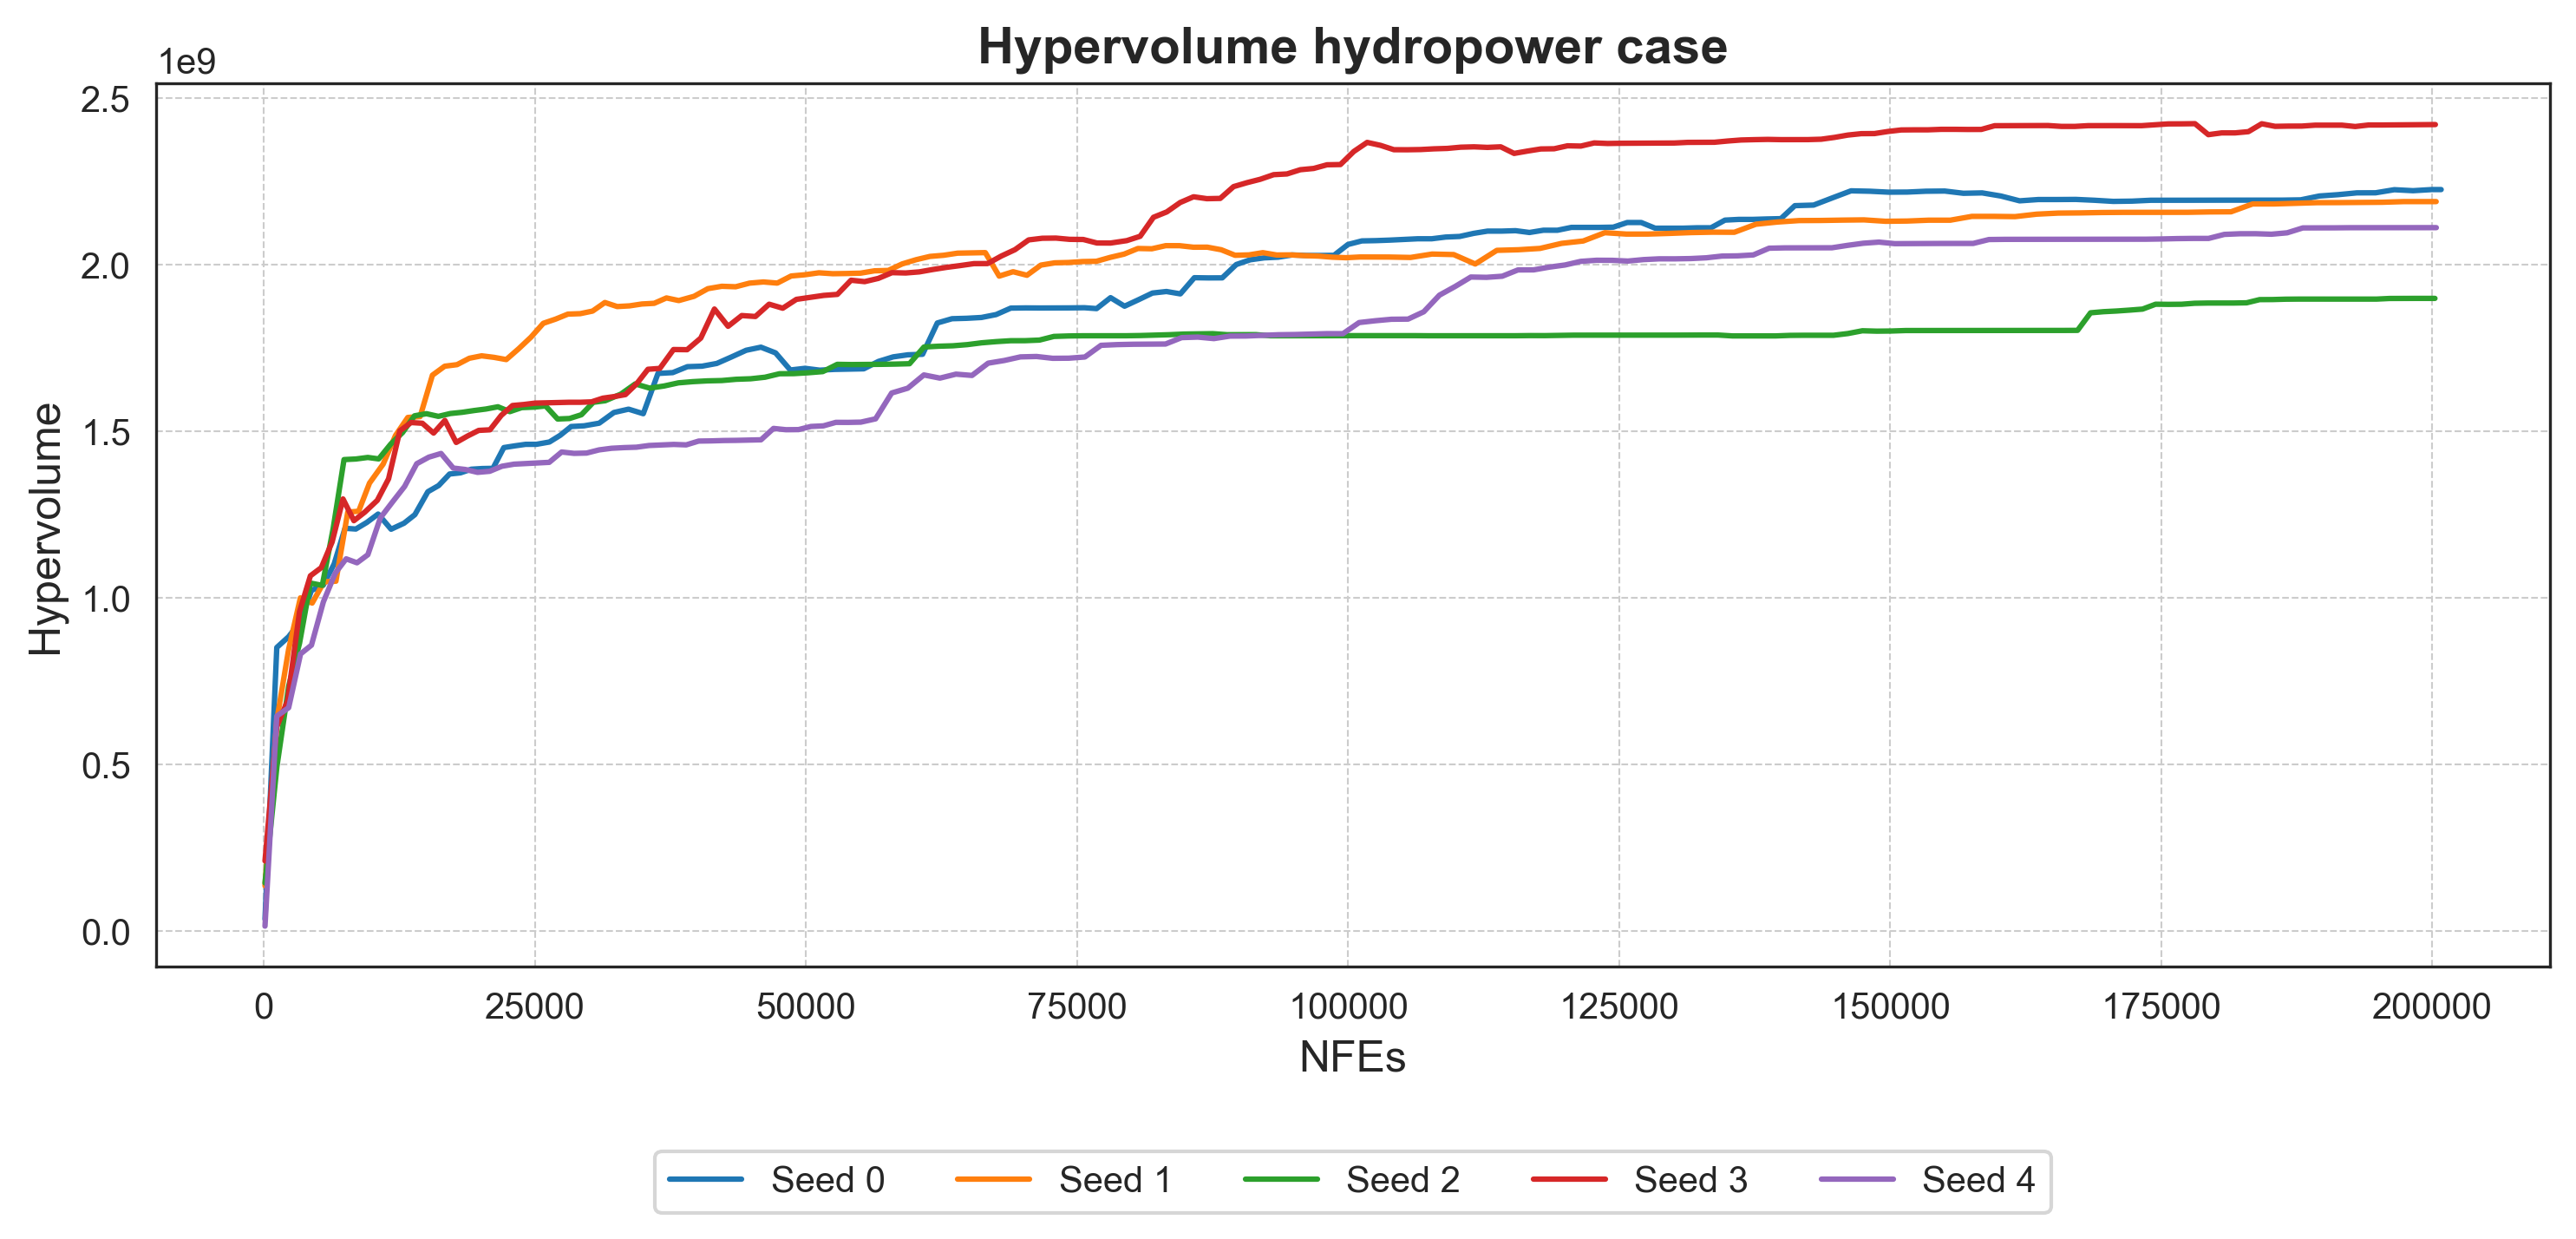

C:\Users\whitl\OneDrive\Documenten\MASTER\Year 2\THESIS\16.02.22.Multiobjective\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\ZambeziSmashPython\runs\HYD_pseudo_200000nfe_5seed


In [349]:
hvs_dict, norm_hvs_dict = process_archives(seeds, worst_array, norm_worst_array)

hvs_dicts = [hvs_dict]

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)

# Iterate through dictionaries and plot lines
for i, hvs_dict in enumerate(hvs_dicts, start=1):
    for seed, values in hvs_dict.items():
        x = list(values.keys())
        y = list(values.values())
        ax.plot(x, y, label=f'Seed {seed}')

# Customize the plot using ax
ax.set_title('Hypervolume hydropower case', fontsize=14, fontweight='bold')
ax.set_xlabel('NFEs', fontsize=12)
ax.set_ylabel('Hypervolume', fontsize=12)
ax.grid(True, linestyle='--', linewidth=0.5)

# Place the legend at the bottom within the plot
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), fontsize=10, ncol=5)

fig.tight_layout()

# Save the plot
relative_path = '../../plots'
if not os.path.exists(relative_path):
    os.makedirs(relative_path)
filename = f'hyd_{run_comment}_hv.png'  # Assuming run_comment is defined
fig.savefig(os.path.join(relative_path, filename), bbox_inches='tight')

# Show the plot
plt.show()

print(os.getcwd())

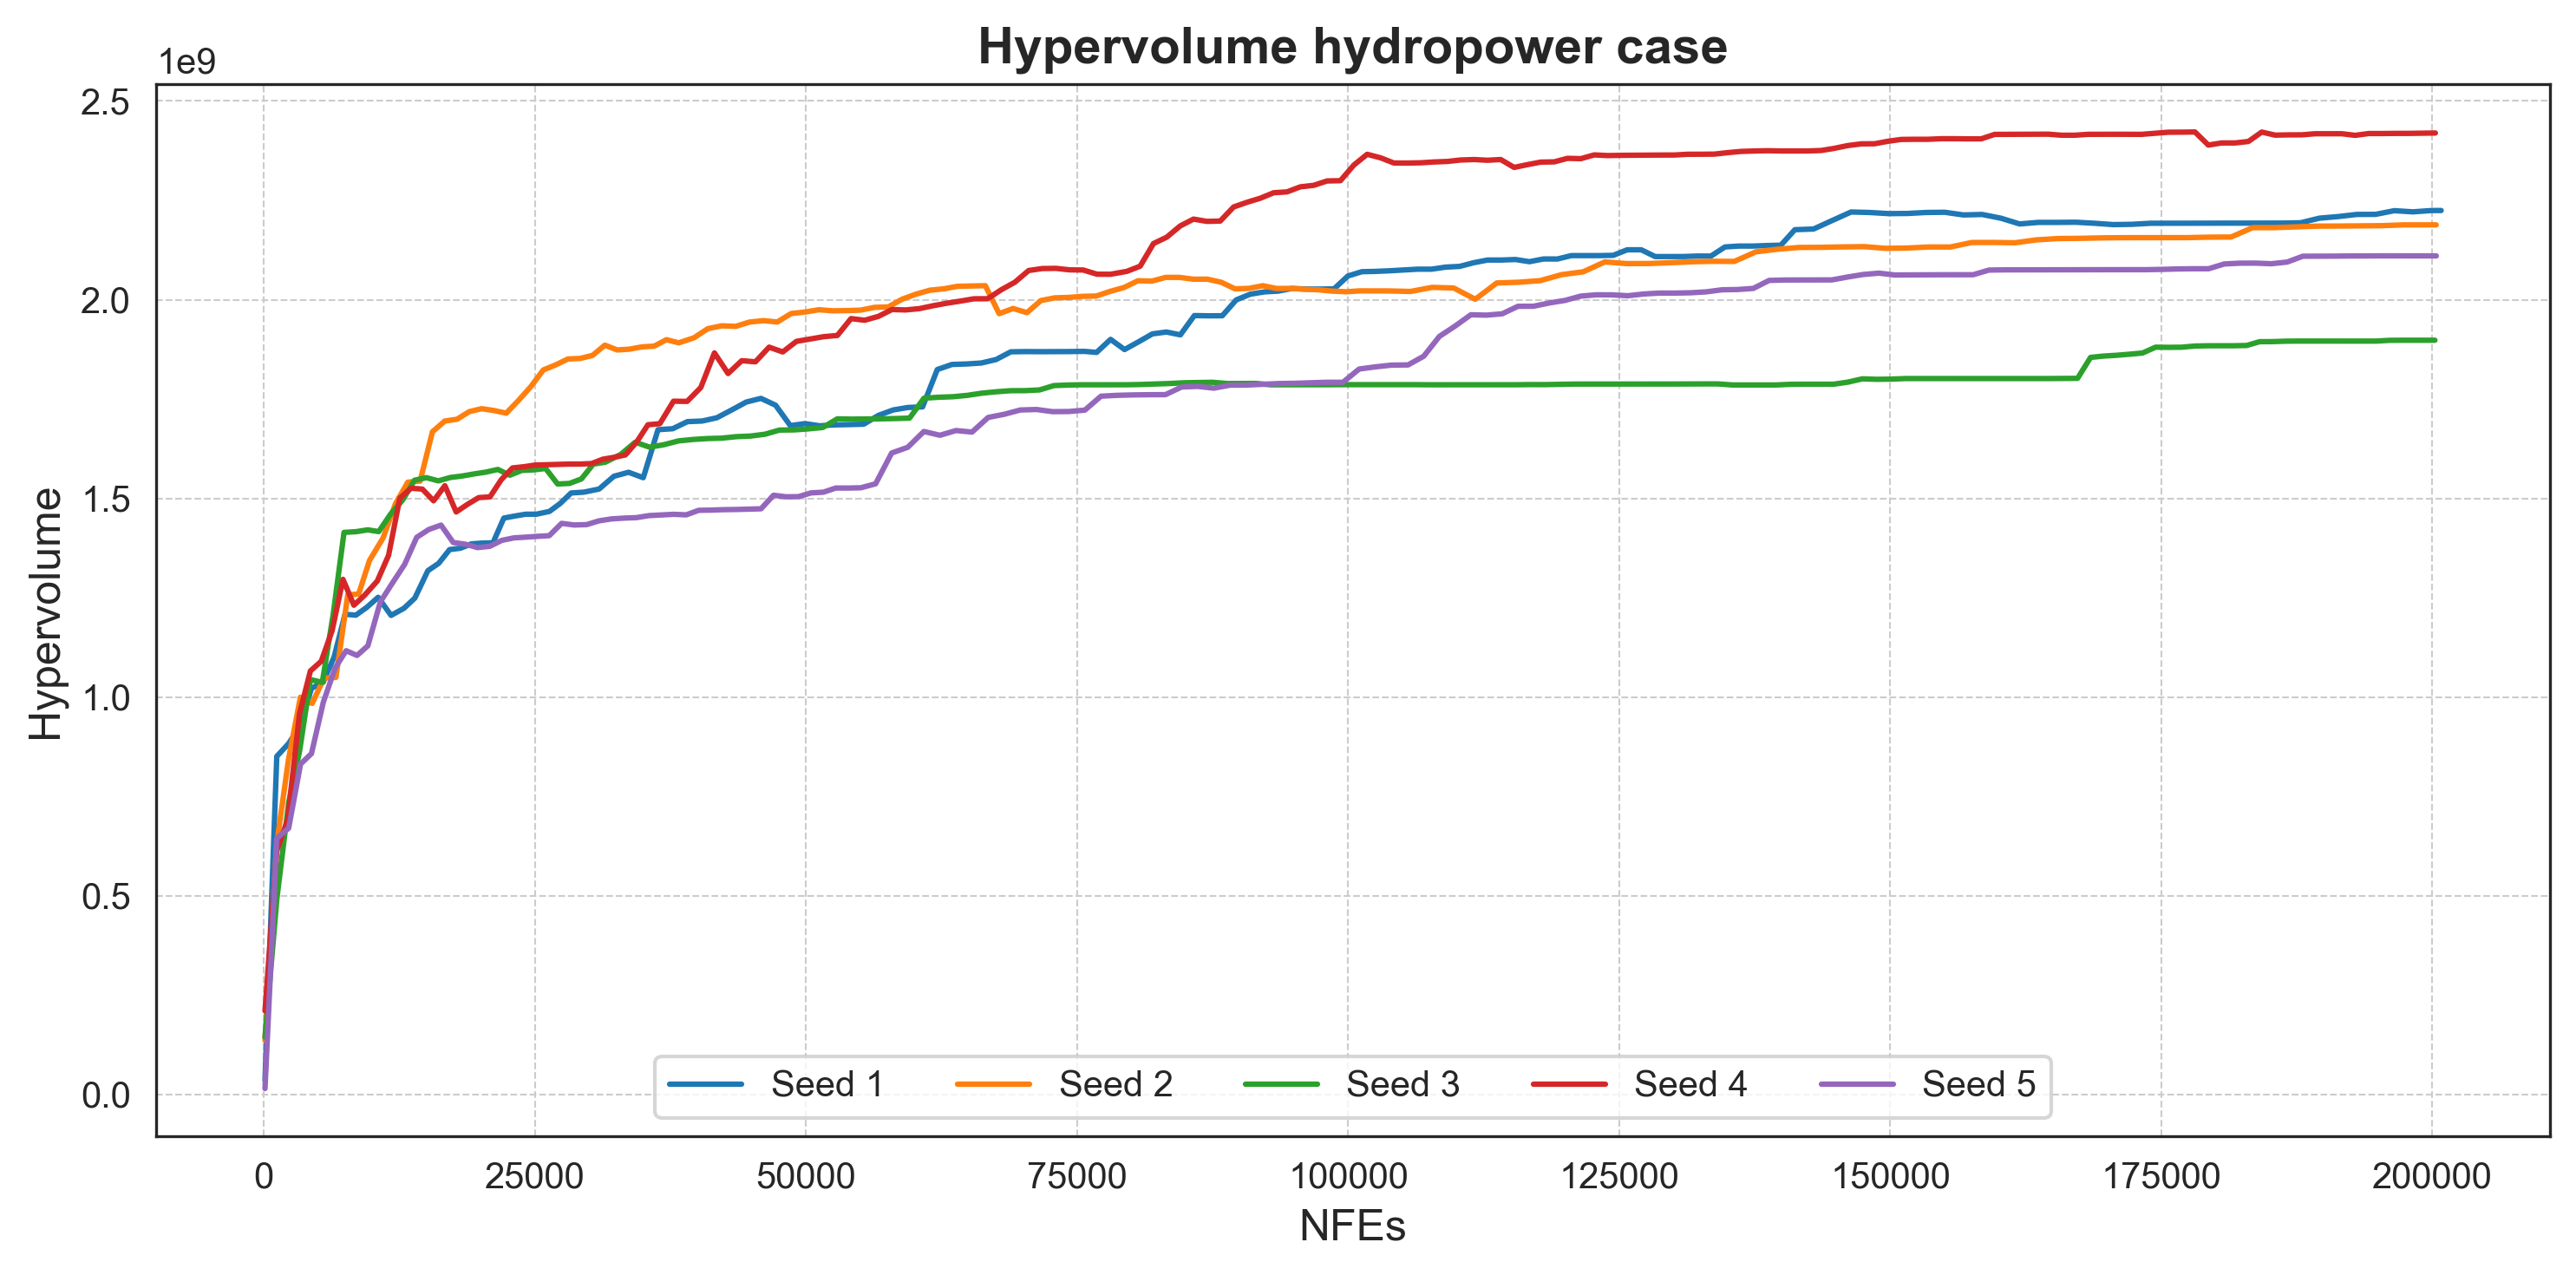

C:\Users\whitl\OneDrive\Documenten\MASTER\Year 2\THESIS\16.02.22.Multiobjective\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\ZambeziSmashPython\runs\HYD_pseudo_200000nfe_5seed


In [350]:
os.chdir('../HYD_pseudo_200000nfe_5seed')

with open('hv_hyd_200.pkl', 'rb') as pickle_file:
    hvs_dict = pickle.load(pickle_file)
    
hvs_dicts = [hvs_dict]

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)

# Iterate through dictionaries and plot lines
for i, hvs_dict in enumerate(hvs_dicts, start=1):
    for seed, values in hvs_dict.items():
        x = list(values.keys())
        y = list(values.values())
        ax.plot(x, y, label=f'Seed {seed}')

# Customize the plot using ax
ax.set_title('Hypervolume hydropower case', fontsize=14, fontweight='bold')
plt.xlabel('NFEs', fontsize=12)
plt.ylabel('Hypervolume', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(['Seed 1', 'Seed 2', 'Seed 3', 'Seed 4', 'Seed 5'], loc='lower center', fontsize=10, ncol=5)
plt.tight_layout()

# Save the plot
relative_path = '../../plots'
filename = f'hv_june_hyd.png'
fig.savefig(os.path.join(relative_path, filename), bbox_inches='tight')

plt.show()

print(os.getcwd())

# FULL DISAGGREGATION 200,000 NFE's, 5 seeds

In [352]:
if not os.path.exists("../src"):
    os.chdir("../../src")
else:
    os.chdir('../src')
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\src'

In [353]:
from model_zambezi_OPT_full import ModelZambezi

ZambeziProblem = ModelZambezi()

def model_wrapper(**kwargs):
    input = [kwargs['v' + str(i)] for i in range(len(kwargs))]
    Hydropower, Environment, Irrigation, Irrigation2, Irrigation3, Irrigation4, Irrigation5, Irrigation6, Irrigation7,\
        Irrigation8, Irrigation9, HydropowerITT, HydropowerKGU, HydropowerKA, HydropowerCB, HydropowerKGL = \
        tuple(ZambeziProblem.evaluate(np.array(input)))
    return Hydropower, Environment, Irrigation, Irrigation2, Irrigation3, Irrigation4, Irrigation5, Irrigation6, \
        Irrigation7, Irrigation8, Irrigation9, HydropowerITT, HydropowerKGU, HydropowerKA, HydropowerCB, HydropowerKGL

# specify model
model = Model('zambeziproblem', function=model_wrapper)

# levers
model.levers = [RealParameter('v' + str(i), -1, 1) for i in range(ZambeziProblem.Nvar)]

# specify outcomes
model.outcomes = [ScalarOutcome('Hydropower', ScalarOutcome.MINIMIZE),  # Minimize, because deficits
                  ScalarOutcome('Environment', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation2', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation3', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation4', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation5', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation6', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation7', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation8', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation9', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerITT', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerKGU', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerKA', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerCB', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerKGL', ScalarOutcome.MINIMIZE),
                  ]
#Problem definitionv
problem = to_problem(model, searchover="levers")

Run definition

In [355]:
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\src'

In [356]:
if not os.path.exists("../src"):
    os.chdir("../../src")
else:
    os.chdir('../src')
os.getcwd()


nfe = 200000 #
seeds = 5
run_comment = 'pseudo'
run_label = f"FULL_{run_comment}_{nfe}nfe_{seeds}seed"

os.chdir(f'../runs/{run_label}')
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\runs\\FULL_pseudo_200000nfe_5seed'

In [357]:
# Get the worst values

# Load the merged results
df = pd.read_csv("merged_results.csv")

column_names = ['Hydropower', 'Environment', 'Irrigation', 'Irrigation2', 'Irrigation3', 'Irrigation4', 'Irrigation5', 'Irrigation6', \
        'Irrigation7', 'Irrigation8', 'Irrigation9', 'HydropowerITT', 'HydropowerKGU', 'HydropowerKA', 'HydropowerCB', 'HydropowerKGL']

df_full = df[column_names]

#Save the worst solutions for the normalization for the hypervolume calculation
worst_hyd = df_full['Hydropower'].max()
worst_irr = df_full['Irrigation'].max()
worst_env = df_full['Environment'].max()
worst_irr2 = df_full['Irrigation2'].max()
worst_irr3 = df_full['Irrigation3'].max()
worst_irr4 = df_full['Irrigation4'].max()
worst_irr5 = df_full['Irrigation5'].max()
worst_irr6 = df_full['Irrigation6'].max()
worst_irr7 = df_full['Irrigation7'].max()
worst_irr8 = df_full['Irrigation8'].max()
worst_irr9 = df_full['Irrigation9'].max()
worst_hydITT = df_full['HydropowerITT'].max()
worst_hydKGU = df_full['HydropowerKGU'].max()
worst_hydKA = df_full['HydropowerKA'].max()
worst_hydCB = df_full['HydropowerCB'].max()
worst_hydKGL = df_full['HydropowerKGL'].max()

worst_list = [worst_hyd, worst_env, worst_irr, worst_irr2, worst_irr3, worst_irr4, worst_irr5, worst_irr6, worst_irr7, worst_irr8, worst_irr9, worst_hydITT, worst_hydKGU, worst_hydKA, worst_hydCB, worst_hydKGL]

worst_array = np.asarray(worst_list)

In [358]:
print(worst_list)

[23.838157777300463, 5358769.785278183, 5.653776487947823, 0.8000278466800381, 0.8881361845011373, 0.8048759992150372, 0.510047185025761, 0.78575031940875, 0.5, 0.9166666666666666, 0.7655057198324526, 0.6045921480271185, 3.789260228644274, 8.144848221478714, 11.413968871110947, 2.9635299851662267]


In [359]:
def alternative_load_archives(filename):
    archives = {}
    norm_archives = {}
    with tarfile.open(os.path.abspath(filename)) as fh:
        for entry in fh.getmembers():
            if entry.name.endswith("csv"):
                key = entry.name.split("/")[1][:-4]
                #print(entry.name)
                df = pd.read_csv(fh.extractfile(entry), usecols = column_names)#, index_col=0
                norm_df = pd.DataFrame()
                norm_df['Hydropower']=(df['Hydropower']-best_hyd)/(worst_hyd-best_hyd)
                norm_df['Environment']=(df['Environment']-best_env)/(worst_env-best_env)
                norm_df['Irrigation']=(df['Irrigation']-best_irr)/(worst_irr-best_irr)
                norm_df['Irrigation2']=(df['Irrigation2']-best_irr2)/(worst_irr2-best_irr2)
                norm_df['Irrigation3']=(df['Irrigation3']-best_irr3)/(worst_irr3-best_irr3)
                norm_df['Irrigation4']=(df['Irrigation4']-best_irr4)/(worst_irr4-best_irr4)
                norm_df['Irrigation5']=(df['Irrigation5']-best_irr5)/(worst_irr5-best_irr5)
                norm_df['Irrigation6']=(df['Irrigation6']-best_irr6)/(worst_irr6-best_irr6)
                norm_df['Irrigation7']=(df['Irrigation7']-best_irr7)/(worst_irr7-best_irr7)
                norm_df['Irrigation8']=(df['Irrigation8']-best_irr8)/(worst_irr8-best_irr8)
                norm_df['Irrigation9']=(df['Irrigation9']-best_irr9)/(worst_irr9-best_irr9)
                norm_df['HydropowerITT'] = (df['HydropowerITT'] - best_hydITT) / (worst_hydITT - best_hydITT)
                norm_df['HydropowerKGU'] = (df['HydropowerKGU'] - best_hydKGU) / (worst_hydKGU - best_hydKGU)
                norm_df['HydropowerKA'] = (df['HydropowerKA'] - best_hydKA) / (worst_hydKA - best_hydKA)
                norm_df['HydropowerCB'] = (df['HydropowerCB'] - best_hydCB) / (worst_hydCB - best_hydCB)
                norm_df['HydropowerKGL'] = (df['HydropowerKGL'] - best_hydKGL) / (worst_hydKGL - best_hydKGL)
                if not df.empty:
                    archives[int(key)] = df
                if not norm_df.empty:
                    norm_archives[int(key)] = norm_df
                    #print(df)
    return archives, norm_archives

ArchiveLogger.load_archives = alternative_load_archives

norm_worst_array = np.ascontiguousarray([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

C:\Users\whitl\OneDrive\Documenten\MASTER\Year 2\THESIS\16.02.22.Multiobjective\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\ZambeziSmashPython\runs\FULL_pseudo_200000nfe_5seed


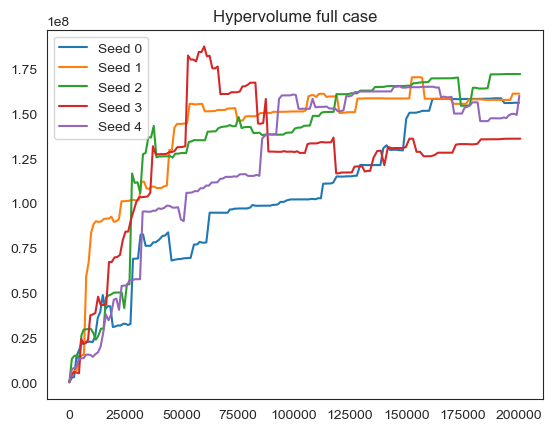

In [360]:
hvs_dict, norm_hvs_dict = process_archives(seeds, worst_array, norm_worst_array)

# Save dictionary to a pickle file
with open('hv_full_200.pkl', 'wb') as pickle_file:
    pickle.dump(hvs_dict, pickle_file)

hvs_dicts = [hvs_dict]

# Iterate through dictionaries and plot lines
for i, hvs_dict in enumerate(hvs_dicts, start=1):
    for seed, values in hvs_dict.items():
        x = list(values.keys())  
        y = list(values.values()) 
        plt.plot(x, y, label=f'Seed {seed}')

plt.title('Hypervolume full case')

plt.legend()

print(os.getcwd())
relative_path = '../../plots'
filename = f'full_{run_comment}_hv.png'  

plt.savefig(os.path.join(relative_path, filename))


df_full_200 = pd.DataFrame.from_dict(hvs_dict)

# FULL 1 mln runs

5 runs of 1,000,000 nfe's are conjoined

In [363]:
if not os.path.exists("../src"):
    os.chdir("../../src")
else:
    os.chdir('../src')
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\src'

In [364]:
from model_zambezi_OPT_full import ModelZambezi

ZambeziProblem = ModelZambezi()

def model_wrapper(**kwargs):
    input = [kwargs['v' + str(i)] for i in range(len(kwargs))]
    Hydropower, Environment, Irrigation, Irrigation2, Irrigation3, Irrigation4, Irrigation5, Irrigation6, Irrigation7,\
        Irrigation8, Irrigation9, HydropowerITT, HydropowerKGU, HydropowerKA, HydropowerCB, HydropowerKGL = \
        tuple(ZambeziProblem.evaluate(np.array(input)))
    return Hydropower, Environment, Irrigation, Irrigation2, Irrigation3, Irrigation4, Irrigation5, Irrigation6, \
        Irrigation7, Irrigation8, Irrigation9, HydropowerITT, HydropowerKGU, HydropowerKA, HydropowerCB, HydropowerKGL

# specify model
model = Model('zambeziproblem', function=model_wrapper)

# levers
model.levers = [RealParameter('v' + str(i), -1, 1) for i in range(ZambeziProblem.Nvar)]

# specify outcomes
model.outcomes = [ScalarOutcome('Hydropower', ScalarOutcome.MINIMIZE),  # Minimize, because deficits
                  ScalarOutcome('Environment', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation2', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation3', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation4', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation5', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation6', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation7', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation8', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation9', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerITT', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerKGU', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerKA', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerCB', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('HydropowerKGL', ScalarOutcome.MINIMIZE),
                  ]
#Problem definitionv
problem = to_problem(model, searchover="levers")

Run definition

In [366]:
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\src'

## Seed 1

In [368]:
if not os.path.exists("../src"):
    os.chdir("../../src")
else:
    os.chdir('../src')
os.getcwd()


nfe = 1000000 #
seeds = 1
run_comment = 'pseudo_mln_1st_seed'
run_label = f"FULL_{run_comment}_{nfe}nfe_{seeds}seed"

os.chdir(f'../runs/{run_label}')
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\runs\\FULL_pseudo_mln_1st_seed_1000000nfe_1seed'

In [369]:
# Get the worst values

# Load the merged results
df = pd.read_csv("merged_results.csv")

column_names = ['Hydropower', 'Environment', 'Irrigation', 'Irrigation2', 'Irrigation3', 'Irrigation4', 'Irrigation5', 'Irrigation6', \
        'Irrigation7', 'Irrigation8', 'Irrigation9', 'HydropowerITT', 'HydropowerKGU', 'HydropowerKA', 'HydropowerCB', 'HydropowerKGL']

df_full = df[column_names]

# Save the worst solutions for the normalization for the hypervolume calculation
worst_hyd = df_full['Hydropower'].max()
worst_irr = df_full['Irrigation'].max()
worst_env = df_full['Environment'].max()
worst_irr2 = df_full['Irrigation2'].max()
worst_irr3 = df_full['Irrigation3'].max()
worst_irr4 = df_full['Irrigation4'].max()
worst_irr5 = df_full['Irrigation5'].max()
worst_irr6 = df_full['Irrigation6'].max()
worst_irr7 = df_full['Irrigation7'].max()
worst_irr8 = df_full['Irrigation8'].max()
worst_irr9 = df_full['Irrigation9'].max()
worst_hydITT = df_full['HydropowerITT'].max()
worst_hydKGU = df_full['HydropowerKGU'].max()
worst_hydKA = df_full['HydropowerKA'].max()
worst_hydCB = df_full['HydropowerCB'].max()
worst_hydKGL = df_full['HydropowerKGL'].max()

worst_list = [worst_hyd, worst_env, worst_irr, worst_irr2, worst_irr3, worst_irr4, worst_irr5, worst_irr6, worst_irr7, worst_irr8, worst_irr9, worst_hydITT, worst_hydKGU, worst_hydKA, worst_hydCB, worst_hydKGL]

worst_array = np.asarray(worst_list)

In [370]:
print(worst_list)

[24.20436447835954, 4582481.665740882, 5.153373652824545, 0.7994597365929279, 0.8804801637920875, 0.8181728831432099, 0.4789686915371461, 0.7160826864449845, 0.5, 0.9166666666666666, 0.781586186689555, 0.5969020092693424, 2.5215356692549182, 8.144848221478714, 12.199718088507352, 2.3334969893074144]


In [371]:
def alternative_load_archives(filename):
    archives = {}
    norm_archives = {}
    with tarfile.open(os.path.abspath(filename)) as fh:
        for entry in fh.getmembers():
            if entry.name.endswith("csv"):
                key = entry.name.split("/")[1][:-4]
                #print(entry.name)
                df = pd.read_csv(fh.extractfile(entry), usecols = column_names)#, index_col=0
                norm_df = pd.DataFrame()
                norm_df['Hydropower']=(df['Hydropower']-best_hyd)/(worst_hyd-best_hyd)
                norm_df['Environment']=(df['Environment']-best_env)/(worst_env-best_env)
                norm_df['Irrigation']=(df['Irrigation']-best_irr)/(worst_irr-best_irr)
                norm_df['HydropowerITT'] = (df['HydropowerITT'] - best_hydITT) / (worst_hydITT - best_hydITT)
                norm_df['HydropowerKGU'] = (df['HydropowerKGU'] - best_hydKGU) / (worst_hydKGU - best_hydKGU)
                norm_df['HydropowerKA'] = (df['HydropowerKA'] - best_hydKA) / (worst_hydKA - best_hydKA)
                norm_df['HydropowerCB'] = (df['HydropowerCB'] - best_hydCB) / (worst_hydCB - best_hydCB)
                norm_df['HydropowerKGL'] = (df['HydropowerKGL'] - best_hydKGL) / (worst_hydKGL - best_hydKGL)
                norm_df['Irrigation2']=(df['Irrigation2']-best_irr2)/(worst_irr2-best_irr2)
                norm_df['Irrigation3']=(df['Irrigation3']-best_irr3)/(worst_irr3-best_irr3)
                norm_df['Irrigation4']=(df['Irrigation4']-best_irr4)/(worst_irr4-best_irr4)
                norm_df['Irrigation5']=(df['Irrigation5']-best_irr5)/(worst_irr5-best_irr5)
                norm_df['Irrigation6']=(df['Irrigation6']-best_irr6)/(worst_irr6-best_irr6)
                norm_df['Irrigation7']=(df['Irrigation7']-best_irr7)/(worst_irr7-best_irr7)
                norm_df['Irrigation8']=(df['Irrigation8']-best_irr8)/(worst_irr8-best_irr8)
                norm_df['Irrigation9']=(df['Irrigation9']-best_irr9)/(worst_irr9-best_irr9)

                if not df.empty:
                    archives[int(key)] = df
                if not norm_df.empty:
                    norm_archives[int(key)] = norm_df
                    #print(df)
    return archives, norm_archives

ArchiveLogger.load_archives = alternative_load_archives

norm_worst_array = np.ascontiguousarray([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

C:\Users\whitl\OneDrive\Documenten\MASTER\Year 2\THESIS\16.02.22.Multiobjective\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\ZambeziSmashPython\runs\FULL_pseudo_mln_1st_seed_1000000nfe_1seed


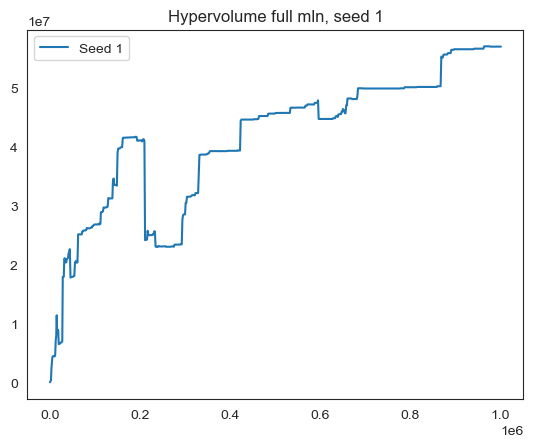

In [372]:
# The dictionaries per run are created in the following cells. For the first run, run the first cell with hvs_dict_1. The second run is in the cell thereafter (hvs_dict_2) etcera.
hvs_dict_1, norm_hvs_dict_1 = process_archives(seeds, worst_array, norm_worst_array)

# Save dictionary to a pickle file
with open('hv_full_mln_1.pkl', 'wb') as pickle_file:
    pickle.dump(hvs_dict_1, pickle_file)
    
hvs_dicts_1 = [hvs_dict_1]

# Iterate through dictionaries and plot lines
for i, hvs_dict_1 in enumerate(hvs_dicts_1, start=1):
    for seed, values in hvs_dict_1.items():
        x = list(values.keys())  # Assuming the keys are x-axis values
        y = list(values.values())  # Assuming the values are y-axis values 
        plt.plot(x, y, label=f'Seed 1')

plt.title(f'Hypervolume full mln, seed 1')
plt.legend()

print(os.getcwd())
relative_path = '../../plots'
filename = f'full_{run_comment}_hv.png'  # Assuming run_comment is defined

plt.savefig(os.path.join(relative_path, filename))

plt.show()


dict_keys([100, 1191, 2191, 3290, 4291, 5291, 6388, 7390, 8391, 9393, 10484, 11599, 12717, 13833, 14952, 16072, 17191, 18308, 19430, 20550, 21671, 22792, 23913, 25035, 26154, 27271, 28393, 29511, 30630, 31750, 32870, 33989, 35107, 36227, 37343, 38556, 40052, 41541, 42541, 44033, 45528, 47027, 48524, 49524, 51022, 52517, 54011, 55509, 57008, 58008, 59504, 61001, 62500, 63994, 65489, 66489, 67489, 68984, 70483, 71484, 72484, 73486, 74487, 75488, 76488, 77488, 78986, 80485, 81485, 82984, 83986, 85484, 86983, 87983, 89482, 90482, 91982, 92983, 93983, 95480, 96976, 98475, 99973, 101472, 102472, 103969, 105468, 106468, 107968, 109466, 110965, 111965, 112965, 113965, 115462, 116463, 117464, 118963, 120461, 121958, 123458, 124458, 125458, 126955, 127956, 129454, 130454, 131456, 132458, 133458, 134458, 135956, 137455, 138455, 139730, 141184, 142639, 144095, 145551, 147006, 148463, 149919, 151373, 152830, 154287, 155742, 157198, 158653, 160109, 161563, 163017, 164474, 165931, 167385, 168842, 170

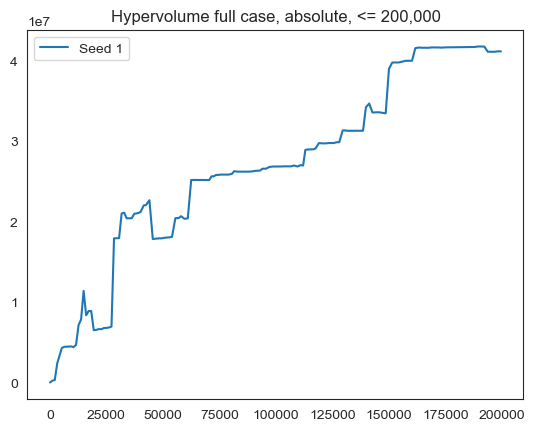

In [373]:
# to visualize the 1 mln run until the 200,000th nfe for comparison with the 5 seed run

#hvs_dict, norm_hvs_dict = process_archives(seeds, worst_array, norm_worst_array)
hvs_dicts_1 = [hvs_dict_1]

# Iterate through dictionaries and plot lines
for i, hvs_dict_1 in enumerate(hvs_dicts_1, start=1):
    for seed, values in hvs_dict_1.items():
        print(values.keys())
        print(type(values.keys()))
        x = [key for key in values.keys() if key <= 200000]
        y = [values[key] for key in x]
        #x = list(values.keys())  
        #y = list(values.values()) 
        plt.plot(x, y, label=f'Seed 1')

plt.title('Hypervolume full case, absolute, <= 200,000')
plt.legend()

print(os.getcwd())
relative_path = '../../plots'
filename = f'full_{run_comment}_200k.png'  # Assuming run_comment is defined

plt.savefig(os.path.join(relative_path, filename))

plt.show()

## Seed 2

In [375]:
if not os.path.exists("../src"):
    os.chdir("../../src")
else:
    os.chdir('../src')
os.getcwd()


nfe = 1000000 #
seeds = 1
run_comment = 'pseudo_mln_2nd_seed'
run_label = f"FULL_{run_comment}_{nfe}nfe_{seeds}seed"

os.chdir(f'../runs/{run_label}')
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\runs\\FULL_pseudo_mln_2nd_seed_1000000nfe_1seed'

In [376]:
# Get the worst values

# Load the merged results
df = pd.read_csv("merged_results.csv")

column_names = ['Hydropower', 'Environment', 'Irrigation', 'Irrigation2', 'Irrigation3', 'Irrigation4', 'Irrigation5', 'Irrigation6', \
        'Irrigation7', 'Irrigation8', 'Irrigation9', 'HydropowerITT', 'HydropowerKGU', 'HydropowerKA', 'HydropowerCB', 'HydropowerKGL']

df_full = df[column_names]

# Save the worst solutions as a reference for the hypervolume calculation
worst_hyd = df_full['Hydropower'].max()
worst_irr = df_full['Irrigation'].max()
worst_env = df_full['Environment'].max()
worst_irr2 = df_full['Irrigation2'].max()
worst_irr3 = df_full['Irrigation3'].max()
worst_irr4 = df_full['Irrigation4'].max()
worst_irr5 = df_full['Irrigation5'].max()
worst_irr6 = df_full['Irrigation6'].max()
worst_irr7 = df_full['Irrigation7'].max()
worst_irr8 = df_full['Irrigation8'].max()
worst_irr9 = df_full['Irrigation9'].max()
worst_hydITT = df_full['HydropowerITT'].max()
worst_hydKGU = df_full['HydropowerKGU'].max()
worst_hydKA = df_full['HydropowerKA'].max()
worst_hydCB = df_full['HydropowerCB'].max()
worst_hydKGL = df_full['HydropowerKGL'].max()

worst_list = [worst_hyd, worst_env, worst_irr, worst_irr2, worst_irr3, worst_irr4, worst_irr5, worst_irr6, worst_irr7, worst_irr8, worst_irr9, worst_hydITT, worst_hydKGU, worst_hydKA, worst_hydCB, worst_hydKGL]

worst_array = np.asarray(worst_list)


In [377]:
print(worst_list)

[23.313436449625517, 4404435.951117269, 5.631344038615632, 0.7988606592839607, 0.8862169988905974, 0.7644011053965325, 0.4828707232301131, 0.7939080712078223, 0.5, 0.9166666666666666, 0.7991813112627725, 0.5955368965364163, 3.892721795630605, 8.15963429266196, 11.88631573442265, 3.060937713184616]


In [378]:
def alternative_load_archives(filename):
    archives = {}
    norm_archives = {}
    with tarfile.open(os.path.abspath(filename)) as fh:
        for entry in fh.getmembers():
            if entry.name.endswith("csv"):
                key = entry.name.split("/")[1][:-4]
                #print(entry.name)
                df = pd.read_csv(fh.extractfile(entry), usecols = column_names)#, index_col=0
                norm_df = pd.DataFrame()
                norm_df['Hydropower']=(df['Hydropower']-best_hyd)/(worst_hyd-best_hyd)
                norm_df['Environment']=(df['Environment']-best_env)/(worst_env-best_env)
                norm_df['Irrigation']=(df['Irrigation']-best_irr)/(worst_irr-best_irr)
                norm_df['HydropowerITT'] = (df['HydropowerITT'] - best_hydITT) / (worst_hydITT - best_hydITT)
                norm_df['HydropowerKGU'] = (df['HydropowerKGU'] - best_hydKGU) / (worst_hydKGU - best_hydKGU)
                norm_df['HydropowerKA'] = (df['HydropowerKA'] - best_hydKA) / (worst_hydKA - best_hydKA)
                norm_df['HydropowerCB'] = (df['HydropowerCB'] - best_hydCB) / (worst_hydCB - best_hydCB)
                norm_df['HydropowerKGL'] = (df['HydropowerKGL'] - best_hydKGL) / (worst_hydKGL - best_hydKGL)
                norm_df['Irrigation2']=(df['Irrigation2']-best_irr2)/(worst_irr2-best_irr2)
                norm_df['Irrigation3']=(df['Irrigation3']-best_irr3)/(worst_irr3-best_irr3)
                norm_df['Irrigation4']=(df['Irrigation4']-best_irr4)/(worst_irr4-best_irr4)
                norm_df['Irrigation5']=(df['Irrigation5']-best_irr5)/(worst_irr5-best_irr5)
                norm_df['Irrigation6']=(df['Irrigation6']-best_irr6)/(worst_irr6-best_irr6)
                norm_df['Irrigation7']=(df['Irrigation7']-best_irr7)/(worst_irr7-best_irr7)
                norm_df['Irrigation8']=(df['Irrigation8']-best_irr8)/(worst_irr8-best_irr8)
                norm_df['Irrigation9']=(df['Irrigation9']-best_irr9)/(worst_irr9-best_irr9)

                if not df.empty:
                    archives[int(key)] = df
                if not norm_df.empty:
                    norm_archives[int(key)] = norm_df
                    #print(df)
    return archives, norm_archives

ArchiveLogger.load_archives = alternative_load_archives

norm_worst_array = np.ascontiguousarray([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

C:\Users\whitl\OneDrive\Documenten\MASTER\Year 2\THESIS\16.02.22.Multiobjective\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\ZambeziSmashPython\runs\FULL_pseudo_mln_2nd_seed_1000000nfe_1seed


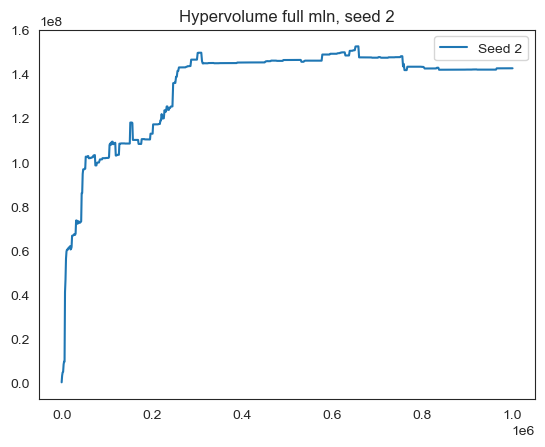

In [379]:
hvs_dict_2, norm_hvs_dict_2 = process_archives(seeds, worst_array, norm_worst_array)
# Save dictionary to a pickle file
with open('hv_full_mln_2.pkl', 'wb') as pickle_file:
    pickle.dump(hvs_dict_2, pickle_file)
    
hvs_dicts_2 = [hvs_dict_2]

# Iterate through dictionaries and plot lines
for i, hvs_dict_2 in enumerate(hvs_dicts_2, start=1):
    for seed, values in hvs_dict_2.items():
        x = list(values.keys())  # Assuming the keys are x-axis values
        y = list(values.values())  # Assuming the values are y-axis values 
        plt.plot(x, y, label=f'Seed 2')

plt.title(f'Hypervolume full mln, seed 2')
plt.legend()

print(os.getcwd())
relative_path = '../../plots'
filename = f'full_{run_comment}_hv.png'  # Assuming run_comment is defined

plt.savefig(os.path.join(relative_path, filename))

plt.show()

dict_keys([100, 1188, 2283, 3379, 4477, 5479, 6577, 7577, 8674, 9773, 10866, 11993, 13117, 14246, 15373, 16503, 17633, 18763, 19890, 21019, 22145, 23273, 24400, 25531, 26662, 27788, 28913, 29946, 31067, 32188, 33310, 34435, 35558, 36686, 37808, 38935, 40061, 41186, 42314, 43438, 44562, 45689, 46815, 47941, 49066, 50191, 51316, 52437, 53561, 54690, 55818, 56942, 58067, 59193, 60322, 61448, 62576, 63704, 64828, 65954, 67078, 68204, 69330, 70457, 71587, 72709, 73835, 74959, 76086, 77212, 78339, 79467, 80595, 81722, 82846, 83971, 85101, 86226, 87355, 88483, 89612, 90735, 91863, 92991, 94118, 95245, 96371, 97497, 98622, 99749, 100876, 102001, 103129, 104252, 105260, 106411, 107561, 108714, 109865, 111014, 112165, 113315, 114463, 115611, 116759, 117907, 119058, 120208, 121362, 122513, 123663, 124809, 125960, 127108, 128258, 129410, 130562, 131715, 132866, 134017, 135170, 136322, 137474, 138623, 139774, 140926, 142077, 143227, 144378, 145526, 146677, 147828, 148979, 150129, 151278, 152430, 15

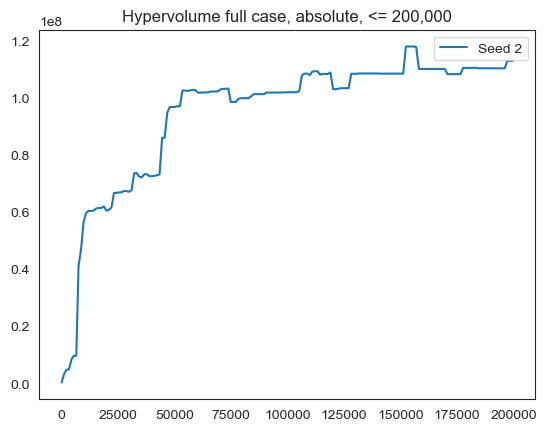

In [380]:
#hvs_dict, norm_hvs_dict = process_archives(seeds, worst_array, norm_worst_array)
hvs_dicts_2 = [hvs_dict_2]

# Iterate through dictionaries and plot lines
for i, hvs_dict_2 in enumerate(hvs_dicts_2, start=1):
    for seed, values in hvs_dict_2.items():
        print(values.keys())
        print(type(values.keys()))
        x = [key for key in values.keys() if key <= 200000]
        y = [values[key] for key in x]
        #x = list(values.keys())  
        #y = list(values.values()) 
        plt.plot(x, y, label=f'Seed 2')

plt.title('Hypervolume full case, absolute, <= 200,000')
plt.legend()

print(os.getcwd())
relative_path = '../../plots'
filename = f'full_{run_comment}_200k.png'  # Assuming run_comment is defined

plt.savefig(os.path.join(relative_path, filename))

plt.show()

## Seed 3

In [382]:
if not os.path.exists("../src"):
    os.chdir("../../src")
else:
    os.chdir('../src')
os.getcwd()


nfe = 1000000 #
seeds = 1
run_comment = 'pseudo_mln_3rd_seed'
run_label = f"FULL_{run_comment}_{nfe}nfe_{seeds}seed"

os.chdir(f'../runs/{run_label}')
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\runs\\FULL_pseudo_mln_3rd_seed_1000000nfe_1seed'

In [383]:
# Get the worst values

# Load the merged results
df = pd.read_csv("merged_results.csv")

column_names = ['Hydropower', 'Environment', 'Irrigation', 'Irrigation2', 'Irrigation3', 'Irrigation4', 'Irrigation5', 'Irrigation6', \
        'Irrigation7', 'Irrigation8', 'Irrigation9', 'HydropowerITT', 'HydropowerKGU', 'HydropowerKA', 'HydropowerCB', 'HydropowerKGL']

df_full = df[column_names]

# Save the worst solutions for the normalization for the hypervolume calculation
worst_hyd = df_full['Hydropower'].max()
worst_irr = df_full['Irrigation'].max()
worst_env = df_full['Environment'].max()
worst_irr2 = df_full['Irrigation2'].max()
worst_irr3 = df_full['Irrigation3'].max()
worst_irr4 = df_full['Irrigation4'].max()
worst_irr5 = df_full['Irrigation5'].max()
worst_irr6 = df_full['Irrigation6'].max()
worst_irr7 = df_full['Irrigation7'].max()
worst_irr8 = df_full['Irrigation8'].max()
worst_irr9 = df_full['Irrigation9'].max()
worst_hydITT = df_full['HydropowerITT'].max()
worst_hydKGU = df_full['HydropowerKGU'].max()
worst_hydKA = df_full['HydropowerKA'].max()
worst_hydCB = df_full['HydropowerCB'].max()
worst_hydKGL = df_full['HydropowerKGL'].max()

worst_list = [worst_hyd, worst_env, worst_irr, worst_irr2, worst_irr3, worst_irr4, worst_irr5, worst_irr6, worst_irr7, worst_irr8, worst_irr9, worst_hydITT, worst_hydKGU, worst_hydKA, worst_hydCB, worst_hydKGL]

worst_array = np.asarray(worst_list)

In [384]:
print(worst_list)

[23.350971031301363, 4744838.051144842, 5.6301450788842695, 0.7994597365929279, 0.8912222439018164, 0.8053717508681727, 0.4866216195468391, 0.7935312493487967, 0.5, 0.9166666666666666, 0.7552446710987024, 0.574910766182294, 2.75669386269967, 8.226458424579063, 10.715627900969844, 2.4105107505532075]


In [385]:
def alternative_load_archives(filename):
    archives = {}
    norm_archives = {}
    with tarfile.open(os.path.abspath(filename)) as fh:
        for entry in fh.getmembers():
            if entry.name.endswith("csv"):
                key = entry.name.split("/")[1][:-4]
                #print(entry.name)
                df = pd.read_csv(fh.extractfile(entry), usecols = column_names)#, index_col=0
                norm_df = pd.DataFrame()
                norm_df['Hydropower']=(df['Hydropower']-best_hyd)/(worst_hyd-best_hyd)
                norm_df['Environment']=(df['Environment']-best_env)/(worst_env-best_env)
                norm_df['Irrigation']=(df['Irrigation']-best_irr)/(worst_irr-best_irr)
                norm_df['HydropowerITT'] = (df['HydropowerITT'] - best_hydITT) / (worst_hydITT - best_hydITT)
                norm_df['HydropowerKGU'] = (df['HydropowerKGU'] - best_hydKGU) / (worst_hydKGU - best_hydKGU)
                norm_df['HydropowerKA'] = (df['HydropowerKA'] - best_hydKA) / (worst_hydKA - best_hydKA)
                norm_df['HydropowerCB'] = (df['HydropowerCB'] - best_hydCB) / (worst_hydCB - best_hydCB)
                norm_df['HydropowerKGL'] = (df['HydropowerKGL'] - best_hydKGL) / (worst_hydKGL - best_hydKGL)
                norm_df['Irrigation2']=(df['Irrigation2']-best_irr2)/(worst_irr2-best_irr2)
                norm_df['Irrigation3']=(df['Irrigation3']-best_irr3)/(worst_irr3-best_irr3)
                norm_df['Irrigation4']=(df['Irrigation4']-best_irr4)/(worst_irr4-best_irr4)
                norm_df['Irrigation5']=(df['Irrigation5']-best_irr5)/(worst_irr5-best_irr5)
                norm_df['Irrigation6']=(df['Irrigation6']-best_irr6)/(worst_irr6-best_irr6)
                norm_df['Irrigation7']=(df['Irrigation7']-best_irr7)/(worst_irr7-best_irr7)
                norm_df['Irrigation8']=(df['Irrigation8']-best_irr8)/(worst_irr8-best_irr8)
                norm_df['Irrigation9']=(df['Irrigation9']-best_irr9)/(worst_irr9-best_irr9)

                if not df.empty:
                    archives[int(key)] = df
                if not norm_df.empty:
                    norm_archives[int(key)] = norm_df
                    #print(df)
    return archives, norm_archives

ArchiveLogger.load_archives = alternative_load_archives

norm_worst_array = np.ascontiguousarray([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

C:\Users\whitl\OneDrive\Documenten\MASTER\Year 2\THESIS\16.02.22.Multiobjective\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\ZambeziSmashPython\runs\FULL_pseudo_mln_3rd_seed_1000000nfe_1seed


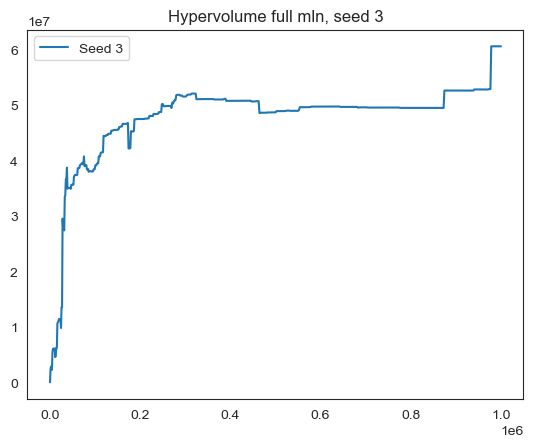

In [386]:
hvs_dict_3, norm_hvs_dict_3 = process_archives(seeds, worst_array, norm_worst_array)
# Save dictionary to a pickle file
with open('hv_full_mln_3.pkl', 'wb') as pickle_file:
    pickle.dump(hvs_dict_3, pickle_file)
    
hvs_dicts_3 = [hvs_dict_3]

# Iterate through dictionaries and plot lines
for i, hvs_dict_3 in enumerate(hvs_dicts_3, start=1):
    for seed, values in hvs_dict_3.items():
        x = list(values.keys())  # Assuming the keys are x-axis values
        y = list(values.values())  # Assuming the values are y-axis values 
        plt.plot(x, y, label=f'Seed 3')

plt.title(f'Hypervolume full mln, seed 3')
plt.legend()

print(os.getcwd())
relative_path = '../../plots'
filename = f'full_{run_comment}_hv.png'  # Assuming run_comment is defined

plt.savefig(os.path.join(relative_path, filename))

plt.show()

dict_keys([100, 1195, 2291, 3385, 4385, 5477, 6481, 7489, 8492, 9585, 10704, 11852, 13003, 14157, 15308, 16461, 17610, 18758, 19909, 21059, 22213, 23362, 24515, 25667, 26823, 27977, 29128, 30422, 31621, 32818, 34016, 35216, 36416, 37615, 38815, 40015, 41214, 42416, 43616, 44816, 46017, 47219, 48417, 49618, 50818, 52019, 53220, 54421, 55621, 56820, 58019, 59214, 60413, 61614, 62813, 64014, 65215, 66412, 67613, 68814, 70108, 71428, 72747, 74067, 75388, 76708, 78024, 79344, 80664, 81982, 83302, 84623, 85941, 87261, 88582, 89901, 91221, 92541, 93860, 95180, 96498, 97818, 99138, 100458, 101778, 103099, 104420, 105738, 107057, 108376, 109695, 111009, 112330, 113649, 114967, 116286, 117604, 118924, 120242, 121561, 122879, 124198, 125514, 126829, 128144, 129464, 130783, 132096, 133416, 134736, 136054, 137373, 138689, 140008, 141325, 142645, 143966, 145286, 146602, 147921, 149240, 150557, 151873, 153192, 154506, 155823, 157139, 158457, 159773, 161091, 162409, 163728, 165045, 166366, 167687, 169

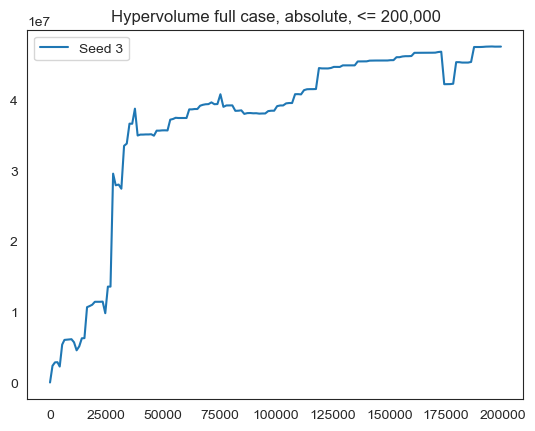

In [387]:
#hvs_dict, norm_hvs_dict = process_archives(seeds, worst_array, norm_worst_array)
hvs_dicts_3 = [hvs_dict_3]

# Iterate through dictionaries and plot lines
for i, hvs_dict_3 in enumerate(hvs_dicts_3, start=1):
    for seed, values in hvs_dict_3.items():
        print(values.keys())
        print(type(values.keys()))
        x = [key for key in values.keys() if key <= 200000]
        y = [values[key] for key in x]
        #x = list(values.keys())  
        #y = list(values.values()) 
        plt.plot(x, y, label=f'Seed 3')

plt.title('Hypervolume full case, absolute, <= 200,000')
plt.legend()

print(os.getcwd())
relative_path = '../../plots'
filename = f'full_{run_comment}_200k.png'  # Assuming run_comment is defined

plt.savefig(os.path.join(relative_path, filename))

plt.show()

## Seed 4

In [389]:
if not os.path.exists("../src"):
    os.chdir("../../src")
else:
    os.chdir('../src')
os.getcwd()


nfe = 1000000 #
seeds = 1
run_comment = 'pseudo_mln_4th_seed'
run_label = f"FULL_{run_comment}_{nfe}nfe_{seeds}seed"

os.chdir(f'../runs/{run_label}')
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\runs\\FULL_pseudo_mln_4th_seed_1000000nfe_1seed'

In [390]:
# Get the worst values

# Load the merged results
df = pd.read_csv("merged_results.csv")

column_names = ['Hydropower', 'Environment', 'Irrigation', 'Irrigation2', 'Irrigation3', 'Irrigation4', 'Irrigation5', 'Irrigation6', \
        'Irrigation7', 'Irrigation8', 'Irrigation9', 'HydropowerITT', 'HydropowerKGU', 'HydropowerKA', 'HydropowerCB', 'HydropowerKGL']

df_full = df[column_names]

# Save the worst solutions for the normalization for the hypervolume calculation
worst_hyd = df_full['Hydropower'].max()
worst_irr = df_full['Irrigation'].max()
worst_env = df_full['Environment'].max()
worst_irr2 = df_full['Irrigation2'].max()
worst_irr3 = df_full['Irrigation3'].max()
worst_irr4 = df_full['Irrigation4'].max()
worst_irr5 = df_full['Irrigation5'].max()
worst_irr6 = df_full['Irrigation6'].max()
worst_irr7 = df_full['Irrigation7'].max()
worst_irr8 = df_full['Irrigation8'].max()
worst_irr9 = df_full['Irrigation9'].max()
worst_hydITT = df_full['HydropowerITT'].max()
worst_hydKGU = df_full['HydropowerKGU'].max()
worst_hydKA = df_full['HydropowerKA'].max()
worst_hydCB = df_full['HydropowerCB'].max()
worst_hydKGL = df_full['HydropowerKGL'].max()

worst_list = [worst_hyd, worst_env, worst_irr, worst_irr2, worst_irr3, worst_irr4, worst_irr5, worst_irr6, worst_irr7, worst_irr8, worst_irr9, worst_hydITT, worst_hydKGU, worst_hydKA, worst_hydCB, worst_hydKGL]

worst_array = np.asarray(worst_list)


In [391]:
print(worst_list)

[24.677977718848293, 4381661.764671757, 5.751644352794917, 0.7979347333580349, 0.8964472101597669, 0.7982703000065963, 0.5263649287701582, 0.7805093340317588, 0.5, 0.9166666666666666, 0.8121847794240841, 0.5334351345231378, 3.3893037164299247, 8.163301499543284, 12.127164029513043, 2.857428493832129]


In [392]:
def alternative_load_archives(filename):
    archives = {}
    norm_archives = {}
    with tarfile.open(os.path.abspath(filename)) as fh:
        for entry in fh.getmembers():
            if entry.name.endswith("csv"):
                key = entry.name.split("/")[1][:-4]
                #print(entry.name)
                df = pd.read_csv(fh.extractfile(entry), usecols = column_names)#, index_col=0
                norm_df = pd.DataFrame()
                norm_df['Hydropower']=(df['Hydropower']-best_hyd)/(worst_hyd-best_hyd)
                norm_df['Environment']=(df['Environment']-best_env)/(worst_env-best_env)
                norm_df['Irrigation']=(df['Irrigation']-best_irr)/(worst_irr-best_irr)
                norm_df['HydropowerITT'] = (df['HydropowerITT'] - best_hydITT) / (worst_hydITT - best_hydITT)
                norm_df['HydropowerKGU'] = (df['HydropowerKGU'] - best_hydKGU) / (worst_hydKGU - best_hydKGU)
                norm_df['HydropowerKA'] = (df['HydropowerKA'] - best_hydKA) / (worst_hydKA - best_hydKA)
                norm_df['HydropowerCB'] = (df['HydropowerCB'] - best_hydCB) / (worst_hydCB - best_hydCB)
                norm_df['HydropowerKGL'] = (df['HydropowerKGL'] - best_hydKGL) / (worst_hydKGL - best_hydKGL)
                norm_df['Irrigation2']=(df['Irrigation2']-best_irr2)/(worst_irr2-best_irr2)
                norm_df['Irrigation3']=(df['Irrigation3']-best_irr3)/(worst_irr3-best_irr3)
                norm_df['Irrigation4']=(df['Irrigation4']-best_irr4)/(worst_irr4-best_irr4)
                norm_df['Irrigation5']=(df['Irrigation5']-best_irr5)/(worst_irr5-best_irr5)
                norm_df['Irrigation6']=(df['Irrigation6']-best_irr6)/(worst_irr6-best_irr6)
                norm_df['Irrigation7']=(df['Irrigation7']-best_irr7)/(worst_irr7-best_irr7)
                norm_df['Irrigation8']=(df['Irrigation8']-best_irr8)/(worst_irr8-best_irr8)
                norm_df['Irrigation9']=(df['Irrigation9']-best_irr9)/(worst_irr9-best_irr9)

                if not df.empty:
                    archives[int(key)] = df
                if not norm_df.empty:
                    norm_archives[int(key)] = norm_df
                    #print(df)
    return archives, norm_archives

ArchiveLogger.load_archives = alternative_load_archives

norm_worst_array = np.ascontiguousarray([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

C:\Users\whitl\OneDrive\Documenten\MASTER\Year 2\THESIS\16.02.22.Multiobjective\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\ZambeziSmashPython\runs\FULL_pseudo_mln_4th_seed_1000000nfe_1seed


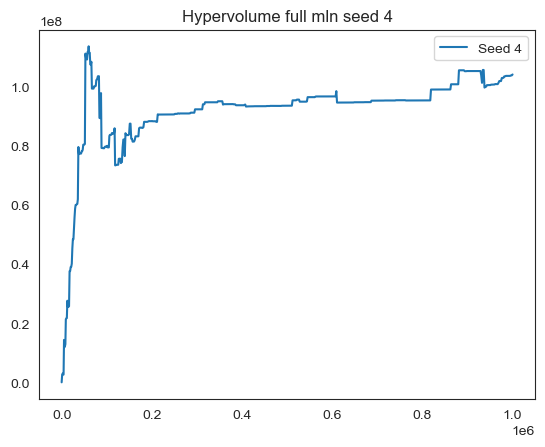

In [393]:
hvs_dict_4, norm_hvs_dict_4 = process_archives(seeds, worst_array, norm_worst_array)

# Save dictionary to a pickle file
with open('hv_full_mln_4.pkl', 'wb') as pickle_file:
    pickle.dump(hvs_dict_4, pickle_file)
    
hvs_dicts_4 = [hvs_dict_4]

# Iterate through dictionaries and plot lines
for i, hvs_dict_4 in enumerate(hvs_dicts_4, start=1):
    for seed, values in hvs_dict_4.items():
        x = list(values.keys())  # Assuming the keys are x-axis values
        y = list(values.values())  # Assuming the values are y-axis values 
        plt.plot(x, y, label=f'Seed 4')

plt.title(f'Hypervolume full mln seed 4')
plt.legend()

print(os.getcwd())
relative_path = '../../plots'
filename = f'full_{run_comment}_hv.png'  # Assuming run_comment is defined

plt.savefig(os.path.join(relative_path, filename))

plt.show()

dict_keys([100, 1184, 2282, 3379, 4382, 5385, 6385, 7389, 8393, 9396, 10422, 11639, 12856, 14077, 15289, 16511, 17729, 18949, 20168, 21389, 22609, 23830, 25052, 26272, 27491, 28709, 29930, 31148, 32369, 33589, 34864, 36065, 37263, 38465, 39666, 40864, 42061, 43262, 44462, 45662, 46865, 48065, 49265, 50466, 51666, 52865, 54066, 55268, 56468, 57668, 58870, 60070, 61272, 62473, 63672, 64871, 66069, 67267, 68470, 69670, 70873, 72071, 73270, 74469, 75884, 77043, 78201, 79361, 80520, 81682, 82841, 83999, 85158, 86315, 87473, 88632, 89792, 90950, 92109, 93268, 94424, 95583, 96744, 97904, 99065, 100225, 101385, 102544, 103702, 104860, 106018, 107178, 108336, 109495, 110654, 111813, 112966, 114122, 115282, 116439, 117598, 118758, 119915, 121076, 122237, 123395, 124554, 125715, 126876, 128034, 129191, 130348, 131508, 132668, 133845, 135434, 137024, 138614, 140205, 141797, 143388, 144975, 146567, 148160, 149752, 151343, 152933, 154524, 156117, 157703, 159294, 160886, 162479, 164069, 165659, 16724

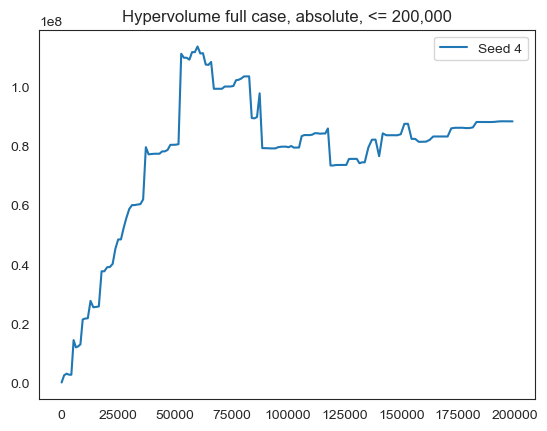

In [394]:
#hvs_dict, norm_hvs_dict = process_archives(seeds, worst_array, norm_worst_array)
hvs_dicts_4 = [hvs_dict_4]

# Iterate through dictionaries and plot lines
for i, hvs_dict_4 in enumerate(hvs_dicts_4, start=1):
    for seed, values in hvs_dict_4.items():
        print(values.keys())
        print(type(values.keys()))
        x = [key for key in values.keys() if key <= 200000]
        y = [values[key] for key in x]
        #x = list(values.keys())  
        #y = list(values.values()) 
        plt.plot(x, y, label=f'Seed 4')

plt.title('Hypervolume full case, absolute, <= 200,000')
plt.legend()

print(os.getcwd())
relative_path = '../../plots'
filename = f'full_{run_comment}_200k.png'  # Assuming run_comment is defined

plt.savefig(os.path.join(relative_path, filename))

plt.show()

## Seed 5

In [396]:
if not os.path.exists("../src"):
    os.chdir("../../src")
else:
    os.chdir('../src')
os.getcwd()


nfe = 1000000 #
seeds = 1
run_comment = 'pseudo_mln_5th_seed'
run_label = f"FULL_{run_comment}_{nfe}nfe_{seeds}seed"

os.chdir(f'../runs/{run_label}')
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\runs\\FULL_pseudo_mln_5th_seed_1000000nfe_1seed'

In [397]:
# Get the worst values

# Load the merged results
df = pd.read_csv("merged_results.csv")

column_names = ['Hydropower', 'Environment', 'Irrigation', 'Irrigation2', 'Irrigation3', 'Irrigation4', 'Irrigation5', 'Irrigation6', \
        'Irrigation7', 'Irrigation8', 'Irrigation9', 'HydropowerITT', 'HydropowerKGU', 'HydropowerKA', 'HydropowerCB', 'HydropowerKGL']

df_full = df[column_names]

# Save the worst solutions as a reference for the hypervolume calculation
worst_hyd = df_full['Hydropower'].max()
worst_irr = df_full['Irrigation'].max()
worst_env = df_full['Environment'].max()
worst_irr2 = df_full['Irrigation2'].max()
worst_irr3 = df_full['Irrigation3'].max()
worst_irr4 = df_full['Irrigation4'].max()
worst_irr5 = df_full['Irrigation5'].max()
worst_irr6 = df_full['Irrigation6'].max()
worst_irr7 = df_full['Irrigation7'].max()
worst_irr8 = df_full['Irrigation8'].max()
worst_irr9 = df_full['Irrigation9'].max()
worst_hydITT = df_full['HydropowerITT'].max()
worst_hydKGU = df_full['HydropowerKGU'].max()
worst_hydKA = df_full['HydropowerKA'].max()
worst_hydCB = df_full['HydropowerCB'].max()
worst_hydKGL = df_full['HydropowerKGL'].max()

worst_list = [worst_hyd, worst_env, worst_irr, worst_irr2, worst_irr3, worst_irr4, worst_irr5, worst_irr6, worst_irr7, worst_irr8, worst_irr9, worst_hydITT, worst_hydKGU, worst_hydKA, worst_hydCB, worst_hydKGL]

worst_array = np.asarray(worst_list)

In [398]:
print(worst_list)

[23.498409125398886, 4598228.6442421805, 5.11376627952726, 0.8000278466800381, 0.8689898588958018, 0.8012592399721211, 0.4951938986588427, 0.7762746853464351, 0.5, 0.9166666666666666, 0.7268849936560933, 0.5304027083104539, 2.5657636566886963, 8.206840800079782, 10.772391014421922, 2.416480439960934]


In [399]:
def alternative_load_archives(filename):
    archives = {}
    norm_archives = {}
    with tarfile.open(os.path.abspath(filename)) as fh:
        for entry in fh.getmembers():
            if entry.name.endswith("csv"):
                key = entry.name.split("/")[1][:-4]
                #print(entry.name)
                df = pd.read_csv(fh.extractfile(entry), usecols = column_names)#, index_col=0
                norm_df = pd.DataFrame()
                norm_df['Hydropower']=(df['Hydropower']-best_hyd)/(worst_hyd-best_hyd)
                norm_df['Environment']=(df['Environment']-best_env)/(worst_env-best_env)
                norm_df['Irrigation']=(df['Irrigation']-best_irr)/(worst_irr-best_irr)
                norm_df['HydropowerITT'] = (df['HydropowerITT'] - best_hydITT) / (worst_hydITT - best_hydITT)
                norm_df['HydropowerKGU'] = (df['HydropowerKGU'] - best_hydKGU) / (worst_hydKGU - best_hydKGU)
                norm_df['HydropowerKA'] = (df['HydropowerKA'] - best_hydKA) / (worst_hydKA - best_hydKA)
                norm_df['HydropowerCB'] = (df['HydropowerCB'] - best_hydCB) / (worst_hydCB - best_hydCB)
                norm_df['HydropowerKGL'] = (df['HydropowerKGL'] - best_hydKGL) / (worst_hydKGL - best_hydKGL)
                norm_df['Irrigation2']=(df['Irrigation2']-best_irr2)/(worst_irr2-best_irr2)
                norm_df['Irrigation3']=(df['Irrigation3']-best_irr3)/(worst_irr3-best_irr3)
                norm_df['Irrigation4']=(df['Irrigation4']-best_irr4)/(worst_irr4-best_irr4)
                norm_df['Irrigation5']=(df['Irrigation5']-best_irr5)/(worst_irr5-best_irr5)
                norm_df['Irrigation6']=(df['Irrigation6']-best_irr6)/(worst_irr6-best_irr6)
                norm_df['Irrigation7']=(df['Irrigation7']-best_irr7)/(worst_irr7-best_irr7)
                norm_df['Irrigation8']=(df['Irrigation8']-best_irr8)/(worst_irr8-best_irr8)
                norm_df['Irrigation9']=(df['Irrigation9']-best_irr9)/(worst_irr9-best_irr9)

                if not df.empty:
                    archives[int(key)] = df
                if not norm_df.empty:
                    norm_archives[int(key)] = norm_df
                    #print(df)
    return archives, norm_archives

ArchiveLogger.load_archives = alternative_load_archives

norm_worst_array = np.ascontiguousarray([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

C:\Users\whitl\OneDrive\Documenten\MASTER\Year 2\THESIS\16.02.22.Multiobjective\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\ZambeziSmashPython\runs\FULL_pseudo_mln_5th_seed_1000000nfe_1seed


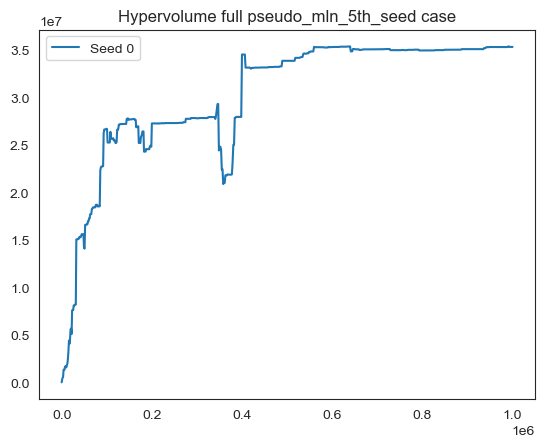

In [400]:
hvs_dict_5, norm_hvs_dict_5 = process_archives(seeds, worst_array, norm_worst_array)

# Save dictionary to a pickle file
with open('hv_full_mln_5.pkl', 'wb') as pickle_file:
    pickle.dump(hvs_dict_5, pickle_file)
    
hvs_dicts_5 = [hvs_dict_5]

# Iterate through dictionaries and plot lines
for i, hvs_dict_5 in enumerate(hvs_dicts_5, start=1):
    for seed, values in hvs_dict_5.items():
        x = list(values.keys())  # Assuming the keys are x-axis values
        y = list(values.values())  # Assuming the values are y-axis values 
        plt.plot(x, y, label=f'Seed {seed}')

plt.title(f'Hypervolume full {run_comment} case')
plt.legend()

print(os.getcwd())

plt.show()

C:\Users\whitl\OneDrive\Documenten\MASTER\Year 2\THESIS\16.02.22.Multiobjective\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\ZambeziSmashPython\runs\FULL_pseudo_mln_5th_seed_1000000nfe_1seed


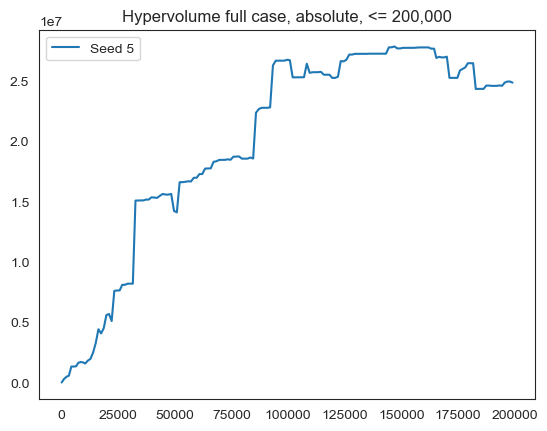

In [401]:
#hvs_dict, norm_hvs_dict = process_archives(seeds, worst_array, norm_worst_array)
hvs_dicts_5 = [hvs_dict_5]

# Iterate through dictionaries and plot lines
for i, hvs_dict_5 in enumerate(hvs_dicts_5, start=1):
    for seed, values in hvs_dict_5.items():
        x = [key for key in values.keys() if key <= 200000]
        y = [values[key] for key in x]
        plt.plot(x, y, label=f'Seed 5')

plt.title('Hypervolume full case, absolute, <= 200,000')
plt.legend()

print(os.getcwd())
relative_path = '../../plots'
filename = f'full_{run_comment}_200k.png'  # Assuming run_comment is defined

plt.savefig(os.path.join(relative_path, filename))

plt.show()

## Combining the different seeds 

In [403]:
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\runs\\FULL_pseudo_mln_5th_seed_1000000nfe_1seed'

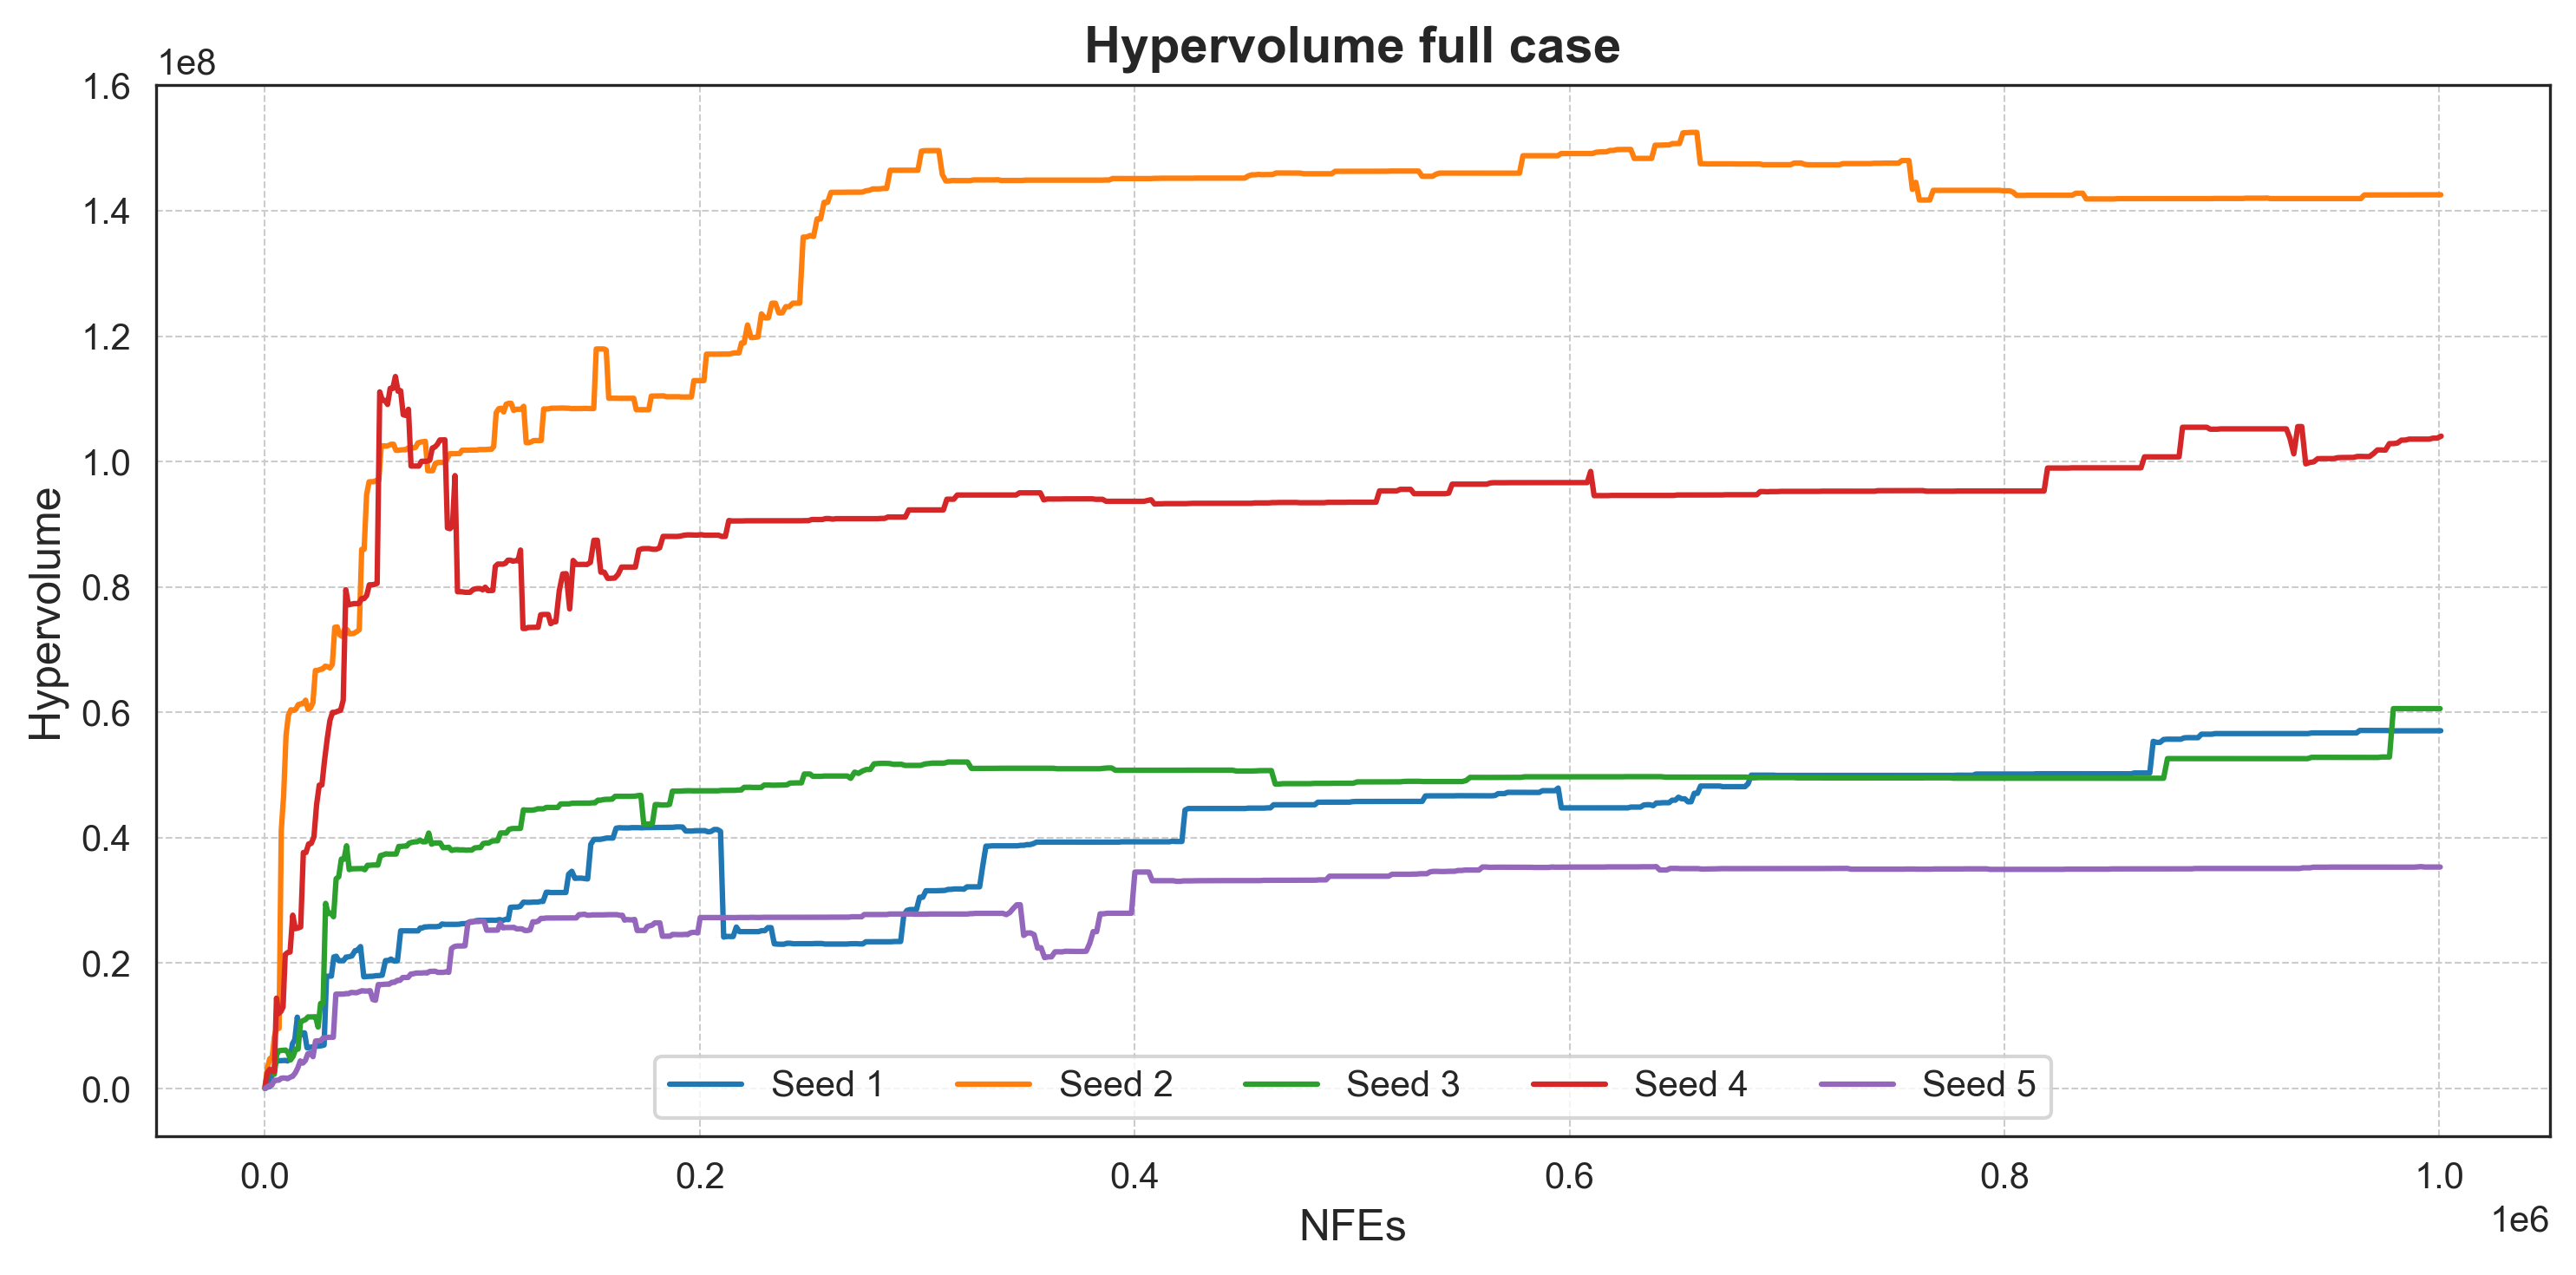

In [404]:
if os.path.exists("../../runs"):
    os.chdir("../../runs")
else:
    os.getcwd()


# Specify the paths to each pickle file
paths = [
    './FULL_pseudo_mln_1st_seed_1000000nfe_1seed/hv_full_mln_1.pkl',
    './FULL_pseudo_mln_2nd_seed_1000000nfe_1seed/hv_full_mln_2.pkl',
    './FULL_pseudo_mln_3rd_seed_1000000nfe_1seed/hv_full_mln_3.pkl',
    './FULL_pseudo_mln_4th_seed_1000000nfe_1seed/hv_full_mln_4.pkl',
    './FULL_pseudo_mln_5th_seed_1000000nfe_1seed/hv_full_mln_5.pkl'
]

# Load the dictionaries from their respective files
hvs_dicts = []
for path in paths:
    with open(path, 'rb') as pickle_file:
        hvs_dicts.append(pickle.load(pickle_file))

# Assign to individual variables if needed
hvs_dict_1, hvs_dict_2, hvs_dict_3, hvs_dict_4, hvs_dict_5 = hvs_dicts

colors = ['blue', 'orange', 'green', 'red', 'purple']

# Create dataframes and seed labels
for i in [hvs_dict_1, hvs_dict_2, hvs_dict_3, hvs_dict_4, hvs_dict_5]:
    df1=pd.DataFrame.from_dict(hvs_dict_1)
    df1 = df1.rename(columns={0: "Seed 1"})
    df2=pd.DataFrame.from_dict(hvs_dict_2)
    df2 = df2.rename(columns={0: "Seed 2"})
    df3=pd.DataFrame.from_dict(hvs_dict_3)
    df3 = df3.rename(columns={0: "Seed 3"})    
    df4=pd.DataFrame.from_dict(hvs_dict_4)
    df4 = df4.rename(columns={0: "Seed 4"})    
    df5=pd.DataFrame.from_dict(hvs_dict_5)
    df5 = df5.rename(columns={0: "Seed 5"})
    
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)

df1.plot(ax=ax)
df2.plot(ax=ax)
df3.plot(ax=ax)
df4.plot(ax=ax)
df5.plot(ax=ax)

plt.title('Hypervolume full case', fontsize=14, fontweight='bold')
plt.xlabel('NFEs', fontsize=12)
plt.ylabel('Hypervolume', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(['Seed 1', 'Seed 2', 'Seed 3', 'Seed 4', 'Seed 5'], loc='lower center', fontsize=10, ncol=5)
plt.tight_layout()

plt.show()

relative_path = '../plots'
filename = f'hv_full_june_1mln_all_seeds.png'
fig.savefig(os.path.join(relative_path, filename), bbox_inches='tight')
